# CS 4650/7650 - Natural Language - HW - 1 
Georgia Tech, Summer 2025 (Instructor: Kartik Goyal)

Welcome to the first full programming assignment for CS 4650/7650! 

In this assignment, you will be implementing different deep learning models for text classification using the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/). It is esentially classifying news articles into different topics. This assignment will start with with data preprocessing techniques, implementing a baseline, and building up from there to more advanced model. It will cover basics of attention mechanism, something very central to modern NLP systems, and present you an opportunity to analyse different aspects of your training model.

This assignment will help you diver deeper into the world of Neural Networks and how to implement them for one application in Natural Language Processing. You are expected to have a good understanding of NumPy and PyTorch before starting this assignment.

- NumPy Quickstarter Guide: https://numpy.org/doc/stable/user/quickstart.html
- A good tutorial on PyTorch: https://www.youtube.com/watch?v=OIenNRt2bjg
- Detailed Documentation of PyTorch: https://pytorch.org/docs/stable/index.html
- Lecture Material on PyTorch and HuggingFace: https://github.com/neelabhsinha/cs7650-gatech-nlp-pytorch-huggingface-tutorial

DO NOT CHANGE the names of any of the files and contents outside the cells where you have to write code.

NOTE: DO NOT USE ANY OTHER EXTERNAL LIBRARIES FOR THIS ASSIGNMENT

<font color='red'> DEADLINE: July 21, 2025, 11:59 PM  </font><br>

The assignment is broken down into 6 Sections. The sections are as follows:

| Section | Part                                      | Points |
|---------|-------------------------------------------|--------|
| 1       | Loading and Preprocessing Data            | 7      |
| 2       | Neural Bag of Words (NBOW)                | 3      |
| 3       | Model Training (utilities for all models) | 15     |  
| 4       | Deep Averaging Networks (DANs)            | 8      |
| 5       | Attention-based Models                    | 30     |
| 6       | Perceptron and Hinge Losses               | 16     |
| 7       | Analysis                                  | 21     |
| 8       | Bonus: Improving Attention Models         | 10     |
| -       | Total                                     | 100 + 10 = 110     |


All the best and happy coding!

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys

# Check what version of Python is running
print(sys.version)

3.11.13 (main, Jun  5 2025, 13:12:00) [GCC 11.2.0]


In [2]:
# export
import os

In [3]:
# folder_path = '/content/drive/My Drive/path/to/folder/HW0'
# the above is what folder path should look like the folder path if you execute in colab
folder_path = '.'

# Files in the folder -
os.listdir(folder_path)
os.chdir(folder_path)

In [4]:
# DO NOT CHANGE THIS CELL
# RUN THIS CELL ONLY IF RUNNING ON PACE-ICE 

# You can ignore this cell if you have already changed the symlink of .cache/ to a location in scratch folder


# override the huggingface cache path and nltk cache path
dirs = {
    "HF_HOME":"~/scratch/hf_cache",
    "TRITON_CACHE_DIR":"~/scratch/triton_cache",
    "TORCHINDUCTOR_CACHE_DIR":"~/scratch/inductor_cache",
    'NLTK_DATA':"~/scratch/nltk_data"
}

for name in dirs:
    d = dirs[name]
    path = os.path.expanduser(d)
    print(name)
    print(path)
    os.makedirs(path, exist_ok=True)
    # making sure the cache dirs are rwx for owner
    os.chmod(path, 0o700)
    os.environ[name] = path


HF_HOME
/home/jblevins32/scratch/hf_cache
TRITON_CACHE_DIR
/home/jblevins32/scratch/triton_cache
TORCHINDUCTOR_CACHE_DIR
/home/jblevins32/scratch/inductor_cache
NLTK_DATA
/home/jblevins32/scratch/nltk_data


In [5]:
# export
# Importing required libraries
# Do not change the libraries already imported or import additional libraries
import torch
import torch.nn as nn
import random
import numpy as np
from collections import Counter
import re
import html
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# export
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [7]:
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
#export
# Defining global constants - DO NOT CHANGE THESE VALUES (except batch size if you have memory issues)
RANDOM_SEED = 42
PADDING_VALUE = 0
UNK_VALUE     = 1
BATCH_SIZE = 128

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))

In [9]:
# This is how we select a GPU if it's available on your computer or in the Colab environment.
print('Device of execution - ', device)

Device of execution -  cuda


## 1. Preprocessing [7 points - Programming]

### 1.1. Data Cleaning Methods [0 points]
The following cell defines some methods to clean the dataset. Do not edit it, but feel free to take a look at some of the operations it's doing.


In [10]:
#export
# example code taken from fast-bert
# DO NOT CHANGE THIS CELL

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

### 1.2. Data Cleaning and Tokenizing [0 points]

Clean the data using the methods above and tokenize it using NLTK

In [11]:
# DO NOT CHANGE THIS CELL
# Downloading the NLTK tokenizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Tokenizing the text
df = pd.read_csv("vocab.csv")
df["tokenized"] = df["data"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
func = lambda x: int(x) if x.isdigit() else x
df['target'] = df['target'].apply(func)
print(df.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jblevins32/scratch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jblevins32/scratch/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(16962, 4)


In [12]:
# DO NOT CHANGE THESE VALUES
# Divide the dataset into training and validation sets
# The following two lines are used to load the indices of the training and validation sets
train_indices = np.load("train_indices.npy")
val_indices = np.load("valid_indices.npy")
# The following two lines are used to select the training and validation sets from the dataframe based on the indices loaded above
train_data = df.iloc[train_indices].reset_index(drop=True)
val_data = df.iloc[val_indices].reset_index(drop=True)
func = lambda x: int(x) if str(x).isdigit() else x
val_data['target'] = val_data['target'].apply(func)
val_data = val_data.iloc[1:, :].reset_index(drop=True)

Here's what the dataset looks like. You can index into specific rows with pandas, and try to guess some of these yourself :). If you're unfamiliar with pandas, it's a extremely useful and popular library for data analysis and manipulation. You can find their documentation [here](https://pandas.pydata.org/docs/).

Pandas primary data structure is a DataFrame. The following cell will print out the basic information of this structure, including the labeled axes (both columns and rows) as well as show you what the first n (default=5) rows look like

In [13]:
# Print training and validation set heads
train_data.head()

,data,target,target_names,tokenized
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,9,rec.sport.baseball,"[from, :, mamatha, devineni, ratnam, <, mr47+,..."
1,From: glazier@isr.harvard.edu (Andrew Baker Gl...,6,misc.forsale,"[from, :, glazier, @, isr.harvard.edu, (, andr..."
2,From: simon@dcs.warwick.ac.uk (Simon Clippingd...,0,alt.atheism,"[from, :, simon, @, dcs.warwick.ac.uk, (, simo..."
3,From: keith@cco.caltech.edu (Keith Allan Schne...,0,alt.atheism,"[from, :, keith, @, cco.caltech.edu, (, keith,..."
4,From: mz@moscom.com (Matthew Zenkar)\\nSubject...,1,comp.graphics,"[from, :, mz, @, moscom.com, (, matthew, zenka..."


In [14]:
# DO NOT CHANGE THIS CELL
id2label = dict(zip(df['target'], df['target_names']))
id2label = {k: id2label[k] for k in id2label if isinstance(k, int)}
id2label = {k: id2label[k] for k in sorted(id2label)}
id2label

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

This is a dictionary which maps ids to label names. It will be handy in the later part of the assignment.

### 1.3. Vocabulary Building [2 points - Programming]

Generate a vocabulary map for all the words in your dataset

Now that we've loaded this dataset, we need to create a vocab map for words, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs. **Go to the following cell, and fill out generate_vocab_map.**

In [15]:
# export

def generate_vocab_map(df, cutoff=2):
    """
    This method takes a dataframe and builds a vocabulary to unique number map.
    It uses the cutoff argument to remove rare words occurring <= cutoff times.
    "" and "UNK" are reserved tokens in our vocab that will be useful later. 
    You'll also find the Counter imported for you to be useful as well.
    
    Args:
        df (pandas.DataFrame) : The entire dataset this mapping is built from
        cutoff (int) : We exclude words from the vocab that appear less than or equal to cutoff
             
    Returns:
        vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
            unique integer ID. Only elements that appear > cutoff times appear in vocab. 
        reversed_vocab (dict[int] = str) : A reversed version of vocab, which allows us to retrieve
            words given their unique integer ID. This map will allow us to "decode" integer 
            sequences we'll encode using vocab!
    """
    vocab = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    count = Counter(vocab.keys())
    reversed_vocab = {}

    ## YOUR CODE STARTS HERE ##
    # hint: start by iterating over df["tokenized"]
    for tokens in df["tokenized"]:
        for token in tokens:
            if token not in vocab:
                count.update([token])
                if count[token] > cutoff:
                    vocab[token] = len(vocab)

    # Create the reversed vocabulary
    for item in vocab.items():
        reversed_vocab[item[1]] = item[0]

    ## YOUR CODE ENDS HERE ##

    return vocab, reversed_vocab

With the methods you have implemented above, you can now generate your dictionaries mapping from word tokens to IDs (and vice versa).

In [16]:
# DO NOT CHANGE THIS CELL
train_vocab, reverse_vocab = generate_vocab_map(train_data)

In [17]:
# Check Vocabulary Size - DO NOT CHANGE THIS VALUE
assert len(train_vocab) == 60233, f"Vocabulary is of incorrect size: {len(train_vocab)}"

# No error means you've passed the test!

### 1.4. Building a Dataset Class [2 points - Programming]

PyTorch has custom Dataset Classes that have very useful extensions, we want to turn our current pandas DataFrame into a subclass of Dataset so that we can iterate and sample through it for minibatch updates. **In the following cell, fill out the HeadlineDataset class.** Refer to PyTorch documentation on [Dataset Classes](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
for help.

In [18]:
#export

class HeadlineDataset(Dataset):
    """
    This class takes a Pandas DataFrame and wraps in a Torch Dataset.
    Read more about Torch Datasets here:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self, vocab, df, max_length=200):
        """
        Initialize the class with appropriate instance variables. In this method, we 
        STRONGLY recommend storing the dataframe itself as an instance variable, and 
        keeping this method very simple. Leave processing to __getitem__.
        
        Args:
            vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
                unique integer ID. Only elements that appear > cutoff times appear in vocab. 
            df (pandas.DataFrame) : The entire dataset this mapping is built from
            max_length (int) : The max length of a headline we'll allow in our dataset.
            
        Returns:
            None
        """
        
        ## YOUR CODE STARTS HERE - initialize parameters ##

        self.vocab = vocab
        self.df = df
        self.max_length = max_length

        ## YOUR CODE ENDS HERE ##
    
    def __len__(self):
        """
        This method returns the length of the underlying dataframe,
        Args:
            None
        Returns:
            df_len (int) : The length of the underlying dataframe
        """

        df_len = None
        
        ## YOUR CODE STARTS HERE ##
        
        df_len = len(self.df)

        ## YOUR CODE ENDS HERE ##
        
        return df_len
    
    def __getitem__(self, index: int):
        """
        This method converts a dataframe row (row["tokenized"]) to an encoded torch LongTensor,
        using our vocab map created using generate_vocab_map. Restricts the encoded headline
        length to max_length.
        
        The purpose of this method is to convert the row - a list of words - into a corresponding
        list of numbers.
        
        i.e. using a map of {"hi": 2, "hello": 3, "UNK": 0}
        this list ["hi", "hello", "NOT_IN_DICT"] will turn into [2, 3, 0]
        
        Args:
            index (int) : The index of the dataframe we want to retrieve.
            
        Returns:
            tokenized_word_tensor (torch.LongTensor) : A 1D tensor of type Long, that has each
                token in the dataframe mapped to a number. These numbers are retrieved from the
                vocab_map we created in generate_vocab_map.
                
                IMPORTANT: If we filtered out the word because it's infrequent (and it doesn't
                exist in the vocab) we need to replace it w/ the UNK token
                
            curr_label (int) : Label index of the class between 0 to len(num_classes) - 1 representing which 
            class label does this data instance belong to
        """
        
        tokenized_word_tensor = []
        
        ## YOUR CODE STARTS HERE ##

        # Iterate through words to create tokenized_word_tensor
        for word in self.df.iloc[index]["tokenized"]:
            if word not in self.vocab:
                tokenized_word_tensor.append(self.vocab["UNK"])
            else:
                tokenized_word_tensor.append(self.vocab[word])

            if len(tokenized_word_tensor) >= self.max_length:
                break

        tokenized_word_tensor = torch.LongTensor(tokenized_word_tensor)
        curr_label = self.df.iloc[index]["target"]

        ## YOUR CODE ENDS HERE ##
        
        return tokenized_word_tensor, curr_label

In [19]:
# DO NOT CHANGE THIS CELL
train_dataset = HeadlineDataset(train_vocab, train_data)
val_dataset   = HeadlineDataset(train_vocab, val_data)

# Now that we're wrapping our dataframes in PyTorch datsets, we can make use of PyTorch Random Samplers, they'll define how our DataLoaders sample elements from the HeadlineDatasets
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

In [20]:
# Check Dataset Lengths - DO NOT CHANGE THESE VALUES
assert len(train_dataset) == 15076, f"Training Dataset is of incorrect size {len(train_dataset)}"
assert len(val_dataset)   ==  1885, f"Validation Dataset is of incorrect size {len(val_dataset)}"

# No error means you've passed the test!

### 1.5. Finalizing our DataLoader [3 points - Programming]

We can now use PyTorch DataLoaders to batch our data for us. **In the following cell fill out collate_fn.** Refer to PyTorch documentation on [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for help. Apply padding and other post-processing required here.

In [21]:
#export

def collate_fn(batch, padding_value=PADDING_VALUE):
    """
    This function is passed as a parameter to Torch DataSampler. collate_fn collects
    batched rows, in the form of tuples, from a DataLoader and applies some final
    pre-processing.
    
    Objective:
    In our case, we need to take the batched input array of 1D tokenized_word_tensors,
    and create a 2D tensor that's padded to be the max length from all our tokenized_word_tensors
    in a batch. We're moving from a Python array of tuples, to a padded 2D tensor.
    
    *HINT*: you're allowed to use torch.nn.utils.rnn.pad_sequence (ALREADY IMPORTED)
    
    Finally, you can read more about collate_fn here: https://pytorch.org/docs/stable/data.html
    
    :param batch: PythonArray[tuple(tokenized_word_tensor: 1D Torch.LongTensor, curr_label: int)] of length BATCH_SIZE
    :param padding_value: int
    
    :return padded_tokens: 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    :return y_labels: 1D FloatTensor of shape (BATCH_SIZE)
    """
        
    ## YOUR CODE STARTS HERE - take the input and target from batch, pad the tokens, convert batches to tensor ##

    # Unzip the batch
    token_tensors, labels = zip(*batch)

    # Pad the token tensors to the maximum length in the batch
    padded_tokens = torch.nn.utils.rnn.pad_sequence(token_tensors, batch_first=True, padding_value=padding_value)
    
    y_labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to a tensor of type long


    ## YOUR CODE ENDS HERE ##
    
    return padded_tokens, y_labels

In [22]:
# DO NOT CHANGE THIS CELL
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

In [23]:
# Use this to test your collate_fn implementation.
# You can look at the shapes of x and y or put print statements in collate_fn while running this snippet
# DO NOT CHANGE THIS CELL

for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break

x: torch.Size([128, 200])
y: torch.Size([128])


## 2. Neural Bag of Words (NBOW) [3 pts - Programming]
Let's move to modeling, now that we have dataset iterators that batch our data for us. The first model is a simple model called NBOW-RAND.

In the following code block, you'll build a feed-forward neural network implementing a neural bag-of-words baseline, NBOW-RAND, described in section 2.1 of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf). You'll find [this](https://pytorch.org/docs/stable/nn.html) page useful for understanding the different layers and [this](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) page useful for how to put them into action.

The core idea behind this baseline is that after we embed each word for a document, we average the embeddings to produce a single vector that hopefully captures some general information spread across the sequence of embeddings. This means we first turn each document of length *n* into a matrix of *nxd*, where *d* is the dimension of the embedding. Then we average this matrix to produce a vector of length *d*, summarizing the contents of the document and proceed with the rest of the network.

While you're working through this implementation, keep in mind how the dimensions change and what each axes represents, as documents will be passed in as minibatches requiring careful selection of which axes you apply certain operations too. Stick to only the architecture described in the instructions below, do not add additional layers, this will impact the validity of local checks.

Refer to the following equation on how to define NBOW -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{avg}) $$

where $w \in R^d$ is a parameter vector.

*HINT*: In the forward step, the BATCH_SIZE is the first dimension.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.

#### 2.1. Define the NBOW model class [3 points]

In [24]:
#export

class NBOW(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 3 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    #
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super().__init__()
        ## YOUR CODE STARTS HERE ##

        # batch size x vocab size x embedding_dim x num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_classes, bias=False)
        self.softmax = nn.Softmax(dim=-1) 

        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #   
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## Hint: Make sure to handle the case where x contains pad tokens. We don't want to consider them in our average.
        ## YOUR CODE STARTS HERE ##
        # print(x.shape)
        avg = self.get_h_avg(x)
        out = self.linear(avg)
        return out

        ## YOUR CODE ENDS HERE ##
    
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)
        
        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight. Ensure you aren't recording gradients for this.
        Hint: Refer to nn.Parameter to do this.
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###

    def get_h_avg(self, x):
        '''
        This function returns the average of the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        embeddings = self.get_embeddings(x)
        mask = (x!= PADDING_VALUE)

        # Count the number of non-padding tokens in each sequence for averaging later
        num_non_pads = mask.sum(dim=1).unsqueeze(-1)

        # Apply the mask to the embeddings
        embeddings = embeddings * mask.unsqueeze(-1) 

        avg =  embeddings.sum(dim=1)/num_non_pads # gives batch_size x 1

        return avg
        ### YOUR CODE ENDS HERE ###

In [25]:
# local test for sanity:
# DO NOT CHANGE THIS CELL

def nbow_test_local():
    embedding_dim = 10
    vocab_size = 5
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.1)
    input = torch.arange(12).reshape(2,6) % vocab_size
    expected_result = torch.tensor(
        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def nbow_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def nbow_test_local_h_avg():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    h_avg = model.get_h_avg(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_h_avg = torch.tensor([[0.1320, 0.1520, 0.1720],
                                  [0.1200, 0.1400, 0.1600]])
    if torch.allclose(h_avg, correct_h_avg, rtol=0.001):
        print("Passed local h_avg test")
    else:
        print(f"h_avg Test failed, expected value was\n{correct_h_avg}\nbut you got:\n{h_avg}")
nbow_test_local()
nbow_test_local_embeddings()
nbow_test_local_h_avg()

Passed local check
Passed local embedding test
Passed local h_avg test


## 3. Model Training [12 points - Programming + 3 points - Non-programming]

Training a PyTorch model involves several key components:

- **Training Loop**: This is the process where the model learns from the training data. In each iteration, the model processes the input data, makes predictions, calculates the loss, and updates its weights using backpropagation.
- **Validation Loop**: Performed after the training loop, this evaluates the model on a separate dataset (validation data) to check its performance. It helps in detecting overfitting.
- **Optimizer**: This is an algorithm that updates the model's weights during training. Common optimizers include SGD, Adam, etc.
- **Criterion (Loss Function)**: This measures how well the model is performing. It calculates the difference between the model's predictions and the actual data. Common loss functions include Mean Squared Error for regression tasks and Cross Entropy Loss for classification.

During training, the optimizer uses the gradient of the loss function to adjust the model's parameters. The model's performance is evaluated periodically on the validation set to monitor its generalization capability. This process continues for a specified number of epochs or until the model achieves a desired level of accuracy.

*Note - In the following code cells (of this section), the above components will be defined. These functions/objects will be used to train and evaluate all your models in this assignment. So, make sure to implement these in a generic way, so that they can be used for all the models.*


### 3.0. Evaluation Metrics [0 points]

Accuracy is a measure used to evaluate classification models, representing the ratio of correctly predicted observations to the total observations. It's simple and intuitive but may not be suitable for imbalanced datasets, as it can be misleading if the class distribution is skewed.

The F1-score, on the other hand, combines precision and recall into a single number. It is particularly useful when dealing with imbalanced datasets or when the cost of false positives and false negatives varies. F1-score provides a better measure of the incorrectly classified cases than the Accuracy Metric. It's calculated as the harmonic mean of precision and recall, thus balancing the two aspects of model performance.

You can read about the terms mentioned above here: https://scikit-learn.org/stable/modules/model_evaluation.html

For this assignment, we are already defining the above metrics for you to use in your implementation

In [26]:
#export
# DO NOT CHANGE THIS CELL
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.
    
    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels
        
    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """
    
    # Get the accuracy
    accuracy = accuracy_score(y_true, y_predicted)
    
    # Get the F1 score
    f1 = f1_score(y_true, y_predicted, average='macro')
    
    return accuracy, f1


In [27]:
# DO NOT CHANGE THIS CELL
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

### 3.1. Criterion [2 points - Programming]

Criterion in PyTorch, refers to the loss function used to evaluate the model's performance. It quantifies how far off the model's predictions are from the actual target values

In PyTorch, **nn.CrossEntropyLoss()** is used for classification tasks. It first does a softmax on the scores, and then calculates the negative log likelihood. This is why you don't need to do sotmax in the model, you can return the scores. In the cell below, implement this.

In [28]:
#export

def get_criterion(loss_type='ce'):
    
    ## YOUR CODE STARTS HERE ##

    criterion = nn.CrossEntropyLoss()

    ## YOUR CODE ENDS HERE ##
    
    return criterion

### 3.2. Optimizer [2 points - Programming]

In PyTorch, an optimizer is a tool that updates the weights of the neural network to minimize the loss. Among these, Adam (Adaptive Moment Estimation) is a widely-used optimizer. Adam combines the best properties of the AdaGrad and RMSProp algorithms to handle sparse gradients on noisy problems. It's known for its effectiveness in deep learning models, especially where large datasets and high-dimensional spaces are involved. Adam adjusts the learning rate during training, making it efficient and effective across a wide range of tasks and model architectures.

In the cell below, define your optimizer. We recommend using Adam, but you are free to experiment with other optimizers as well.

The following function takes a model and learning rate value as input, and defines an optimizer for that model's parameters with that learning rate.

*HINT: model.parameters() can give you all the parameters of a PyTorch model*

In [29]:
#export
def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    
    ## YOUR CODE STARTS HERE ##

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## YOUR CODE ENDS HERE ##
    
    return optimizer

### 3.3. Training Loop [3 points - Programming]

The training loop function in PyTorch is a critical component where the actual learning from data occurs. It typically involves iterating over the training dataset, feeding the data to the model, computing the loss (difference between the predictions and true values), and updating the model's weights.

Creating a training loop involves several steps:

1. Iterate Over Dataset: Loop through the training dataset, often in mini-batches.
2. Forward Pass: Feed the input data to the model to get predictions.
3. Compute Loss: Calculate the loss using a loss function.
4. Backward Pass: Perform backpropagation by calling loss.backward(), which computes the gradient of the loss function with respect to each weight.
5. Update Weights: Use an optimizer (like SGD or Adam) to adjust the weights based on the gradients calculated.
6. Zero the Gradients: Reset the gradients to zero after each mini-batch to prevent accumulation of gradients from multiple passes.

This loop repeats for a specified number of epochs or until a certain level of accuracy or loss is achieved.

In the end, return the mean loss over all samples for this particular iteration

In [30]:
#export
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###

        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        optimizer.zero_grad()  # Zero the gradients before backward pass
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update the model parameters
        total_loss += loss.item()
        
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

### 3.4. Validation Loop [3 points - Programming]

The validation loop in PyTorch is where the model's performance is evaluated on a dataset different from the one used for training. It does not involve updating the model's weights, focusing instead on assessing how well the model generalizes to new data. Here's how it typically works:

1. Iterate Over Validation Dataset: Loop through the validation dataset, usually in mini-batches, without the need for shuffling as in the training loop.
2. Forward Pass: Feed the input data to the model to obtain predictions.
3. Compute Loss: Calculate the loss (e.g., Cross-Entropy, Mean Squared Error) to assess the performance on the validation dataset.
4. Calculate Metrics: Besides loss, other performance metrics like accuracy, F1 score, etc., are computed to evaluate model performance.

Note: No Backpropagation: Unlike the training loop, there is no backward pass or weight updates.

The validation loop is crucial for monitoring overfitting and tuning hyperparameters. It provides insight into how the model is likely to perform on unseen data.

In [31]:
# export
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """
    
    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
        
        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        total_loss += loss.item()

        true.extend(y.cpu().numpy())
        pred.extend(torch.argmax(out, dim=1).cpu().numpy())

    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

### 3.5. Training NBOW [3 points - Non-programming]
Assign and tune the below hyperparameters to optimize your model. Make sure that the output graph of the cell where training happens is clear in your submission.

In [32]:
#export
# Assigning hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_nbow():
  ### your hyper parameters
  learning_rate = 0.001
  epochs = 100
  embedding_dim = 64
  ### 
  return learning_rate, epochs, embedding_dim

Since the NBOW model is rather basic, assuming you haven't added any additional layers, there's really only one hyperparameter for the model architecture: the size of the embedding dimension.

The vocab_size parameter here is based on the number of unique words kept in the vocab after removing those occurring too infrequently, so this is determined by our dataset and is in turn not a true hyperparameter (though the cutoff we used previously might be). The embedding_dim parameter dictates what size vector each word can be embedded as.

A special note concerning the model initialization: We're specifically sending the model to the device set in Part 1, to speed up training if the GPU is available. **Be aware**, you'll have to ensure other tensors are on the same device inside your training and validation loops.

In [33]:
# export
def get_nbow_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the NBOW model.
    """
    model = None
    # Define a model and return
    # YOUR CODE STARTS HERE
    
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    
    # YOUR CODE ENDS HERE
    return model

In [34]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_nbow = []
val_loss_over_time_nbow = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    train_loss_over_time_nbow.append(train_loss)
    val_loss_over_time_nbow.append(val_loss)
save_checkpoint(nbow_model, 'nbow')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 128.60it/s]


Epoch 1 -- Train_Loss: 2.965334556870541 -- Val_Loss: 2.9345444361368815 -- Val_Accuracy: 0.12572944297082228 -- Val_F1: 0.09749102670840339


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.93it/s]


Epoch 2 -- Train_Loss: 2.8874851869324507 -- Val_Loss: 2.845849943161011 -- Val_Accuracy: 0.22652519893899203 -- Val_F1: 0.19097289011664606


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.35it/s]


Epoch 3 -- Train_Loss: 2.7728387582100043 -- Val_Loss: 2.7204082171122232 -- Val_Accuracy: 0.2992042440318302 -- Val_F1: 0.2676705574553285


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.22it/s]


Epoch 4 -- Train_Loss: 2.6201239501015614 -- Val_Loss: 2.5636462052663167 -- Val_Accuracy: 0.3915119363395225 -- Val_F1: 0.3612336277565067


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.54it/s]


Epoch 5 -- Train_Loss: 2.4384892734430603 -- Val_Loss: 2.388662910461426 -- Val_Accuracy: 0.46206896551724136 -- Val_F1: 0.43280336859987373


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.78it/s]


Epoch 6 -- Train_Loss: 2.2349548157999073 -- Val_Loss: 2.1961973985036214 -- Val_Accuracy: 0.5416445623342175 -- Val_F1: 0.5122060301198272


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.32it/s]


Epoch 7 -- Train_Loss: 2.017249355881901 -- Val_Loss: 1.9976366917292276 -- Val_Accuracy: 0.5920424403183023 -- Val_F1: 0.5581485161067345


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.73it/s]


Epoch 8 -- Train_Loss: 1.797974514759193 -- Val_Loss: 1.8040063063303629 -- Val_Accuracy: 0.649867374005305 -- Val_F1: 0.622238942961102


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.06it/s]


Epoch 9 -- Train_Loss: 1.587995176598177 -- Val_Loss: 1.620010240872701 -- Val_Accuracy: 0.693368700265252 -- Val_F1: 0.6702621828035346


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.38it/s]


Epoch 10 -- Train_Loss: 1.3945159790879589 -- Val_Loss: 1.4578001022338867 -- Val_Accuracy: 0.7230769230769231 -- Val_F1: 0.701840205478715


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.68it/s]


Epoch 11 -- Train_Loss: 1.2212161502595675 -- Val_Loss: 1.30775306224823 -- Val_Accuracy: 0.7458885941644562 -- Val_F1: 0.7273717458748494


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.46it/s]


Epoch 12 -- Train_Loss: 1.0694544891179618 -- Val_Loss: 1.182483156522115 -- Val_Accuracy: 0.7649867374005305 -- Val_F1: 0.7513543900963481


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.90it/s]


Epoch 13 -- Train_Loss: 0.938195568525185 -- Val_Loss: 1.0724498788515726 -- Val_Accuracy: 0.7925729442970822 -- Val_F1: 0.7817513584213988


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.44it/s]


Epoch 14 -- Train_Loss: 0.8253914860345549 -- Val_Loss: 0.9808224638303121 -- Val_Accuracy: 0.8090185676392573 -- Val_F1: 0.8000105434866975


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.46it/s]


Epoch 15 -- Train_Loss: 0.7286223067065417 -- Val_Loss: 0.8954545736312867 -- Val_Accuracy: 0.8238726790450929 -- Val_F1: 0.8150926402470298


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.98it/s]


Epoch 16 -- Train_Loss: 0.6454464596206859 -- Val_Loss: 0.8244219223658243 -- Val_Accuracy: 0.8360742705570292 -- Val_F1: 0.8291281128310903


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.64it/s]


Epoch 17 -- Train_Loss: 0.5737723632384155 -- Val_Loss: 0.765794555346171 -- Val_Accuracy: 0.8429708222811672 -- Val_F1: 0.8364704238636648


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.08it/s]


Epoch 18 -- Train_Loss: 0.5122319012880325 -- Val_Loss: 0.714454694588979 -- Val_Accuracy: 0.8503978779840848 -- Val_F1: 0.8438726392566556


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.03it/s]


Epoch 19 -- Train_Loss: 0.4587389013524783 -- Val_Loss: 0.6676409999529521 -- Val_Accuracy: 0.8578249336870026 -- Val_F1: 0.8525397343317271


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.40it/s]


Epoch 20 -- Train_Loss: 0.4123928160485575 -- Val_Loss: 0.6317224820454915 -- Val_Accuracy: 0.8657824933687003 -- Val_F1: 0.8610060547142744


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.36it/s]


Epoch 21 -- Train_Loss: 0.37177234029365797 -- Val_Loss: 0.5962967038154602 -- Val_Accuracy: 0.8737400530503979 -- Val_F1: 0.8688799903527131


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.21it/s]


Epoch 22 -- Train_Loss: 0.3360401977926998 -- Val_Loss: 0.5645981748898824 -- Val_Accuracy: 0.8769230769230769 -- Val_F1: 0.8721262565220103


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.03it/s]


Epoch 23 -- Train_Loss: 0.3046875829666348 -- Val_Loss: 0.5406590004762014 -- Val_Accuracy: 0.8811671087533156 -- Val_F1: 0.876202112024199


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.48it/s]


Epoch 24 -- Train_Loss: 0.27626496667073946 -- Val_Loss: 0.51531809369723 -- Val_Accuracy: 0.8843501326259947 -- Val_F1: 0.8795071547444232


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.17it/s]


Epoch 25 -- Train_Loss: 0.25159173926054423 -- Val_Loss: 0.4945639173189799 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8847297131276275


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.79it/s]


Epoch 26 -- Train_Loss: 0.22933055334172006 -- Val_Loss: 0.47424466609954835 -- Val_Accuracy: 0.8928381962864721 -- Val_F1: 0.8886321275073467


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.27it/s]


Epoch 27 -- Train_Loss: 0.2089850435317573 -- Val_Loss: 0.4585464815298716 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8918273785379414


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.83it/s]


Epoch 28 -- Train_Loss: 0.1910681272462263 -- Val_Loss: 0.44337096611658733 -- Val_Accuracy: 0.8992042440318302 -- Val_F1: 0.8948054475607876


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.43it/s]


Epoch 29 -- Train_Loss: 0.17468108464095553 -- Val_Loss: 0.42880330483118695 -- Val_Accuracy: 0.9013262599469496 -- Val_F1: 0.8967386802145573


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.67it/s]


Epoch 30 -- Train_Loss: 0.16027902496063104 -- Val_Loss: 0.4147685945034027 -- Val_Accuracy: 0.9045092838196287 -- Val_F1: 0.89996407506076


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.53it/s]


Epoch 31 -- Train_Loss: 0.14663730517534887 -- Val_Loss: 0.4034494340419769 -- Val_Accuracy: 0.906631299734748 -- Val_F1: 0.9026887443987773


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.76it/s]


Epoch 32 -- Train_Loss: 0.13456965926087508 -- Val_Loss: 0.3934697429339091 -- Val_Accuracy: 0.906631299734748 -- Val_F1: 0.9025812112173925


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.95it/s]


Epoch 33 -- Train_Loss: 0.12349539477441271 -- Val_Loss: 0.3828590194384257 -- Val_Accuracy: 0.9061007957559681 -- Val_F1: 0.9014990161680624


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.65it/s]


Epoch 34 -- Train_Loss: 0.11354630093200732 -- Val_Loss: 0.3747771422068278 -- Val_Accuracy: 0.9087533156498674 -- Val_F1: 0.9046780258461817


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.78it/s]


Epoch 35 -- Train_Loss: 0.10424292261191344 -- Val_Loss: 0.36891355415185295 -- Val_Accuracy: 0.9092838196286472 -- Val_F1: 0.9052194257074628


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.78it/s]


Epoch 36 -- Train_Loss: 0.09585901545518535 -- Val_Loss: 0.360381281375885 -- Val_Accuracy: 0.9119363395225464 -- Val_F1: 0.9075943479839121


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.47it/s]


Epoch 37 -- Train_Loss: 0.08820429213850176 -- Val_Loss: 0.35529800156752267 -- Val_Accuracy: 0.9108753315649868 -- Val_F1: 0.9066139342192485


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.19it/s]


Epoch 38 -- Train_Loss: 0.08121640793979168 -- Val_Loss: 0.34590312639872234 -- Val_Accuracy: 0.9119363395225464 -- Val_F1: 0.9080097119284922


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.83it/s]


Epoch 39 -- Train_Loss: 0.07483044178304026 -- Val_Loss: 0.3419571340084076 -- Val_Accuracy: 0.9129973474801061 -- Val_F1: 0.9090448325432303


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.82it/s]


Epoch 40 -- Train_Loss: 0.06890159056095754 -- Val_Loss: 0.33422712484995526 -- Val_Accuracy: 0.9140583554376658 -- Val_F1: 0.9099362971886883


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.04it/s]


Epoch 41 -- Train_Loss: 0.0635517474453328 -- Val_Loss: 0.33015690247217816 -- Val_Accuracy: 0.9145888594164456 -- Val_F1: 0.9104665235134624


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.74it/s]


Epoch 42 -- Train_Loss: 0.05857409704160892 -- Val_Loss: 0.3265763779481252 -- Val_Accuracy: 0.916710875331565 -- Val_F1: 0.9125348659269564


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.23it/s]


Epoch 43 -- Train_Loss: 0.05406108702201459 -- Val_Loss: 0.31948939760526024 -- Val_Accuracy: 0.9172413793103448 -- Val_F1: 0.9131292259895496


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 150.97it/s]


Epoch 44 -- Train_Loss: 0.04981215946944589 -- Val_Loss: 0.3173970421155294 -- Val_Accuracy: 0.9177718832891246 -- Val_F1: 0.9137486276712398


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.47it/s]


Epoch 45 -- Train_Loss: 0.046049596015679636 -- Val_Loss: 0.31105988621711733 -- Val_Accuracy: 0.9193633952254642 -- Val_F1: 0.9153941700113876


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.78it/s]


Epoch 46 -- Train_Loss: 0.0425306849055371 -- Val_Loss: 0.3107654958963394 -- Val_Accuracy: 0.9214854111405836 -- Val_F1: 0.9176683523858109


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.03it/s]


Epoch 47 -- Train_Loss: 0.039343872470623355 -- Val_Loss: 0.30571712255477906 -- Val_Accuracy: 0.919893899204244 -- Val_F1: 0.9162905076652912


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.51it/s]


Epoch 48 -- Train_Loss: 0.0363329784881513 -- Val_Loss: 0.30490728517373406 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9172364130272541


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.32it/s]


Epoch 49 -- Train_Loss: 0.03370075417935091 -- Val_Loss: 0.3003266235192617 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.9190297521115806


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.00it/s]


Epoch 50 -- Train_Loss: 0.031176685339818568 -- Val_Loss: 0.2995449920495351 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.919379581097598


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.47it/s]


Epoch 51 -- Train_Loss: 0.028855214518952673 -- Val_Loss: 0.29770112931728365 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9178921888033639


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.51it/s]


Epoch 52 -- Train_Loss: 0.02674532410199359 -- Val_Loss: 0.29524291555086773 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.9195358049900358


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.20it/s]


Epoch 53 -- Train_Loss: 0.024835562941192064 -- Val_Loss: 0.2912755052248637 -- Val_Accuracy: 0.9236074270557029 -- Val_F1: 0.9205479738618731


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.78it/s]


Epoch 54 -- Train_Loss: 0.023034181130134453 -- Val_Loss: 0.28901383181413015 -- Val_Accuracy: 0.9236074270557029 -- Val_F1: 0.9206275947467271


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.60it/s]


Epoch 55 -- Train_Loss: 0.02138973600467888 -- Val_Loss: 0.29073897302150725 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.9193355306595643


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.91it/s]


Epoch 56 -- Train_Loss: 0.01988646448037382 -- Val_Loss: 0.28904161949952445 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9202842923928349


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.39it/s]


Epoch 57 -- Train_Loss: 0.018490169615626842 -- Val_Loss: 0.28562442560990653 -- Val_Accuracy: 0.9236074270557029 -- Val_F1: 0.9207896597231546


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.70it/s]


Epoch 58 -- Train_Loss: 0.01719038774085752 -- Val_Loss: 0.28142162760098777 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.92119193753571


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.88it/s]


Epoch 59 -- Train_Loss: 0.016001842584524115 -- Val_Loss: 0.285561207930247 -- Val_Accuracy: 0.9251989389920424 -- Val_F1: 0.9226562936432142


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.45it/s]


Epoch 60 -- Train_Loss: 0.014910485299493549 -- Val_Loss: 0.2799225409825643 -- Val_Accuracy: 0.9251989389920424 -- Val_F1: 0.922209749761229


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.47it/s]


Epoch 61 -- Train_Loss: 0.01388570818245032 -- Val_Loss: 0.28097403844197594 -- Val_Accuracy: 0.9257294429708223 -- Val_F1: 0.9229544942093103


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.41it/s]


Epoch 62 -- Train_Loss: 0.01293598197526851 -- Val_Loss: 0.27848509351412454 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.921444261583499


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.26it/s]


Epoch 63 -- Train_Loss: 0.01207622109075724 -- Val_Loss: 0.27797304689884184 -- Val_Accuracy: 0.9257294429708223 -- Val_F1: 0.9230530592215599


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.09it/s]


Epoch 64 -- Train_Loss: 0.011259808224799522 -- Val_Loss: 0.27629888157049814 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9231558638204304


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.76it/s]


Epoch 65 -- Train_Loss: 0.010527838230669752 -- Val_Loss: 0.27438897887865704 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9239966207112019


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.74it/s]


Epoch 66 -- Train_Loss: 0.009827831539057068 -- Val_Loss: 0.27930231193701427 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9239235499675787


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.66it/s]


Epoch 67 -- Train_Loss: 0.009187596147658966 -- Val_Loss: 0.27596745590368904 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9240176703707228


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 149.96it/s]


Epoch 68 -- Train_Loss: 0.008589686616718516 -- Val_Loss: 0.2728872756163279 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9240176703707228


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.82it/s]


Epoch 69 -- Train_Loss: 0.008048738609462723 -- Val_Loss: 0.2714001466830572 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9234434700032056


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 134.84it/s]


Epoch 70 -- Train_Loss: 0.00757047647641877 -- Val_Loss: 0.27088289757569634 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9239235499675787


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 131.46it/s]


Epoch 71 -- Train_Loss: 0.007064523189170759 -- Val_Loss: 0.2745240102211634 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.924469271498349


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.51it/s]


Epoch 72 -- Train_Loss: 0.006645943939891028 -- Val_Loss: 0.2717570682366689 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9244568235617173


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.40it/s]


Epoch 73 -- Train_Loss: 0.006255400031647187 -- Val_Loss: 0.2726935068766276 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9240128526837216


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.87it/s]


Epoch 74 -- Train_Loss: 0.005880075238518796 -- Val_Loss: 0.27185536126295723 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9245399568160264


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.57it/s]


Epoch 75 -- Train_Loss: 0.00552335755220788 -- Val_Loss: 0.26841997901598613 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9240128526837216


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.86it/s]


Epoch 76 -- Train_Loss: 0.005227701304385723 -- Val_Loss: 0.2668441047271093 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9239792140794622


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.38it/s]


Epoch 77 -- Train_Loss: 0.004903477837599941 -- Val_Loss: 0.2697361578543981 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9244568235617173


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.99it/s]


Epoch 78 -- Train_Loss: 0.004641550350381787 -- Val_Loss: 0.26921290854612984 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9242793555326173


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.45it/s]


Epoch 79 -- Train_Loss: 0.004376332970115088 -- Val_Loss: 0.26788543065389 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9245636084621834


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.31it/s]


Epoch 80 -- Train_Loss: 0.004127151203554881 -- Val_Loss: 0.27007823487122856 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9260250914075876


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.02it/s]


Epoch 81 -- Train_Loss: 0.0039046215124317776 -- Val_Loss: 0.2688322196404139 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9252449797876974


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.50it/s]


Epoch 82 -- Train_Loss: 0.0037071886719046636 -- Val_Loss: 0.2695170114437739 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9252068069027279


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.72it/s]


Epoch 83 -- Train_Loss: 0.003509878183880789 -- Val_Loss: 0.2698377877473831 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9252449797876974


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.90it/s]


Epoch 84 -- Train_Loss: 0.0032983098842077336 -- Val_Loss: 0.2680983285109202 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9247911396318473


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.51it/s]


Epoch 85 -- Train_Loss: 0.003159232433664344 -- Val_Loss: 0.27081699172655743 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9250122354336885


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.62it/s]


Epoch 86 -- Train_Loss: 0.0029697679466631076 -- Val_Loss: 0.2673689176638921 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9255801263174795


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.06it/s]


Epoch 87 -- Train_Loss: 0.002843332565705276 -- Val_Loss: 0.26986986100673677 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9270382230530345


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.16it/s]


Epoch 88 -- Train_Loss: 0.0026947245429964515 -- Val_Loss: 0.26831527749697365 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9254716997195299


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.62it/s]


Epoch 89 -- Train_Loss: 0.0025545461616336795 -- Val_Loss: 0.26988320449988046 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9269805389282425


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.74it/s]


Epoch 90 -- Train_Loss: 0.0024489379789822308 -- Val_Loss: 0.2684660295645396 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9250260457715079


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.47it/s]


Epoch 91 -- Train_Loss: 0.0023073397603446334 -- Val_Loss: 0.2684319972991943 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9251850395549184


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.17it/s]


Epoch 92 -- Train_Loss: 0.002205483748585428 -- Val_Loss: 0.2681411862373352 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9250337092358499


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.38it/s]


Epoch 93 -- Train_Loss: 0.002088626556126085 -- Val_Loss: 0.2697168250878652 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9264920374381134


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.04it/s]


Epoch 94 -- Train_Loss: 0.002009375287235667 -- Val_Loss: 0.2688031514485677 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9259746888255496


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.11it/s]


Epoch 95 -- Train_Loss: 0.0019102673247551262 -- Val_Loss: 0.26896845599015556 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.92608114095204


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.01it/s]


Epoch 96 -- Train_Loss: 0.0018147591514299797 -- Val_Loss: 0.2763387103875478 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9266927217432069


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.01it/s]


Epoch 97 -- Train_Loss: 0.0017234681216581583 -- Val_Loss: 0.2677200486262639 -- Val_Accuracy: 0.929973474801061 -- Val_F1: 0.9274654713317879


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.74it/s]


Epoch 98 -- Train_Loss: 0.0016610725828193887 -- Val_Loss: 0.2696102311213811 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.926609115725725


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.17it/s]


Epoch 99 -- Train_Loss: 0.0015742743897875298 -- Val_Loss: 0.26730041205883026 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9254348060687843


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.30it/s]

Epoch 100 -- Train_Loss: 0.0015096084502825545 -- Val_Loss: 0.26909262239933013 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9255694174628711
Checkpoint saved to /home/jblevins32/NLP_HW1/model_weights/checkpoint_nbow_ce.pt


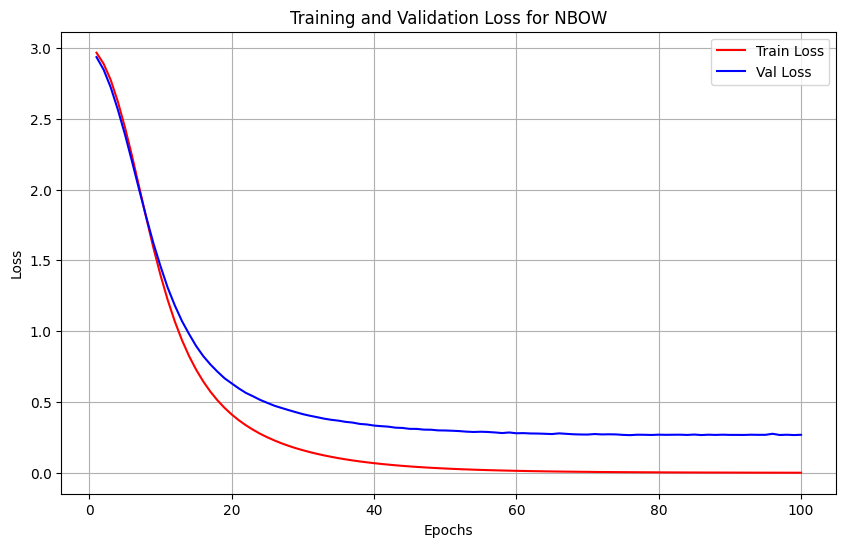

In [35]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits  
plot_loss(train_loss_over_time_nbow, val_loss_over_time_nbow, 'NBOW')

### 3.6. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [36]:
# load best model from checkpoint
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', map_location=device)

# evaluate model 
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.46it/s]

Final Validation Accuracy: 0.9278514588859417
Final Validation F1-Score: 0.9255694174628711


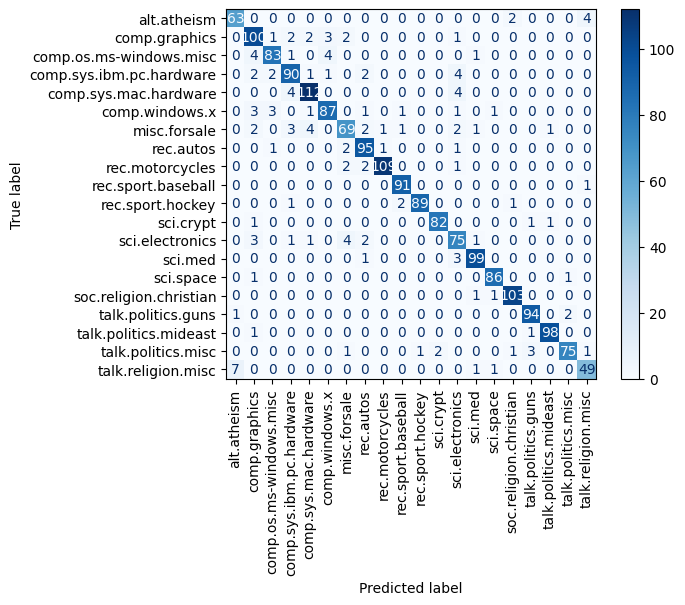

In [37]:
# DO NOT CHANGE THIS CELL 
plot_confusion_matrix(true, pred, classes=id2label.values())

## 4. Simple Deep Averaging Networks (DAN) [5 points - Programming + 3 points - Non-programming]

Now, let's look at how to improve performance of the NBOW model. One such way without drastically changing the model complexity is DAN.

The core idea of a DAN is to simplify the process of understanding text by averaging the embeddings of words in a sentence or document. This creates a single vector representation that captures the overall meaning of the text.

In implementation, a DAN typically involves the following steps:

1. Convert each token into an embedding.
2. Average these embeddings to create a single vector that represents the entire document.
3. Pass this averaged vector through one hidden fully connected neural network layer.
4. Use ReLU activation
5. Use the output of these layers for tasks like classification.

This approach is simpler and often faster than more complex architectures like LSTMs or Transformers, while still providing robust performance for many tasks. However, it might not capture nuances in language as effectively as these more complex models.

*NOTE*: Use the same approach to handle pad_tokens as you used in NBOW.

### 4.1. Model Definition [3 points - Programming]

In the following cell, define the architecture of a DAN in the same way as you implemented NBOW-RAND in Section 2 with. Use the following image as a reference along with Section 3 and Figure 1 (right) of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf).

Refer to the following equation on how to define DAN -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

$$ h_2 = (w_1h_{avg}) $$

$$ h'_{2} = max(0, h_2) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w_2^T h'_{2} + b) $$

where $w \in R^d$ is a parameter vector.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.


In [38]:
# export
class DAN(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 5 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    # 3. A ReLU activation (see nn.ReLU)
    # 4. A linear layer (see nn.Linear)
    #
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=20):
        # voab_size is the size of the vocabulary
        # use bias in your hidden layer
        # embedding_dim is the dimension of the word embeddings
        # hidden_dim is the dimension of the hidden layer outputs, i.e., the 2nd module as per the definition above
        super().__init__()
        ## YOUR CODE STARTS HERE ##
    
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.embedding = nn.Embedding(vocab_size, embedding_dim) # 2 x 5
        self.hidden = nn.Linear(embedding_dim, hidden_dim, bias=False) # 1 x 3
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, num_classes, bias=True)

        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        hidden = self.get_hidden(x) 
        relu_out = self.relu(hidden) 
        lin_out = self.linear(relu_out)  
        return lin_out 

        ## YOUR CODE ENDS HERE ##
    
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)

        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###

        self.embedding.weight = nn.Parameter(weight, requires_grad=False)
        
        ### YOUR CODE ENDS HERE ###
    
    def get_hidden(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###

        embeddings = self.get_embeddings(x)

        mask = (x!= PADDING_VALUE)

        # Count the number of non-padding tokens in each sequence for averaging later
        num_non_pads = mask.sum(dim=1).unsqueeze(-1)

        # Apply the mask to the embeddings
        embeddings = embeddings * mask.unsqueeze(-1) 

        avg_embeddings = embeddings.sum(dim=1)/num_non_pads # gives batch_size x 1
    
        return self.hidden(avg_embeddings)

        ### YOUR CODE ENDS HERE ###
    
    def set_hidden_weight(self, weight, bias):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim, hidden_dim)
            bias: torch.tensor of shape (1, hidden_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.hidden.weight = nn.Parameter(weight, requires_grad=False)
        self.hidden.bias = nn.Parameter(bias.view(-1), requires_grad=False)

        ### YOUR CODE ENDS HERE ###


In [39]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def dan_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = DAN(embedding_dim=embedding_dim, vocab_size=vocab_size, hidden_dim=10)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
    
def dan_test_local_hidden_layer():
    vocab_size = 5
    embedding_dim = 3
    hidden_dim = 3
    
    model = DAN(vocab_size, embedding_dim, hidden_dim)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_hidden_weight(torch.arange(9).reshape(embedding_dim, hidden_dim) / 50, torch.arange(3).reshape(1, hidden_dim) / 50)
    
    output = model.get_hidden(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_output = torch.tensor([[0.0099, 0.0573, 0.1046],
                                    [0.0092, 0.0544, 0.0996]])
    
    if torch.allclose(output, correct_output, atol=0.001):
        print("Passed local hidden layer test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_output}\nbut you got:\n{output}")

dan_test_local_embeddings()
dan_test_local_hidden_layer()

Passed local embedding test
Passed local hidden layer test


### 4.2. DAN Training [3 points - Non-programming]

In this section (and all later sections), you will leverage the same functions defined in Section 3 to train your DAN. To do this, simply initialize your DAN Model and pass that object to the training and evaluation loop to train your model.

Assign and tune the below hyperparameters to optimize your model

In [40]:
# export
def get_dan_model(vocab_size, embedding_dim, hidden_dim):
    """
    This function returns an instance of the DAN model. Initialize the DAN model here and return it. Note that the hidden_dim will be the dimension of the hidden layer in DAN.
    """
    ## YOUR CODE STARTS HERE ##

    model = DAN(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

    ## YOUR CODE ENDS HERE ##
    return model

In [41]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_dan():
  ### your hyper parameters
    learning_rate = 0.001
    epochs = 150
    hidden_layer_dimensions = 100
    embedding_dim = 100
    ### 
    return learning_rate, epochs, hidden_layer_dimensions, embedding_dim


In [42]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
criterion = get_criterion()
optimizer = get_optimizer(dan_model, learning_rate)
train_loss_over_time_dan = []
val_loss_over_time_dan = []
for epoch in range(epochs):
    train_loss = train_loop(dan_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_dan.append(train_loss)
    val_loss_over_time_dan.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(dan_model, 'dan')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.44it/s]


Epoch 1 -- Train_Loss: 2.909276899644884 -- Val_Loss: 2.7778541405995685 -- Val_Accuracy: 0.14907161803713528 -- Val_F1: 0.0926738458301409


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.41it/s]


Epoch 2 -- Train_Loss: 2.5997894133551647 -- Val_Loss: 2.4117671489715575 -- Val_Accuracy: 0.26047745358090185 -- Val_F1: 0.21890730031503763


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.52it/s]


Epoch 3 -- Train_Loss: 2.1804013050208657 -- Val_Loss: 2.006922157605489 -- Val_Accuracy: 0.42015915119363395 -- Val_F1: 0.37842651165507546


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.47it/s]


Epoch 4 -- Train_Loss: 1.7375524892645366 -- Val_Loss: 1.6373154322306316 -- Val_Accuracy: 0.526790450928382 -- Val_F1: 0.4989584365249419


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.49it/s]


Epoch 5 -- Train_Loss: 1.3464010014372356 -- Val_Loss: 1.3323453982671103 -- Val_Accuracy: 0.6143236074270557 -- Val_F1: 0.5981079984151868


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.99it/s]


Epoch 6 -- Train_Loss: 1.042219018532058 -- Val_Loss: 1.1112155079841615 -- Val_Accuracy: 0.676923076923077 -- Val_F1: 0.6654792936982666


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.10it/s]


Epoch 7 -- Train_Loss: 0.8068768447738582 -- Val_Loss: 0.9403775731722513 -- Val_Accuracy: 0.7283819628647215 -- Val_F1: 0.719097493530401


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.55it/s]


Epoch 8 -- Train_Loss: 0.6287095395185179 -- Val_Loss: 0.8256392518679301 -- Val_Accuracy: 0.7623342175066313 -- Val_F1: 0.7545200891055731


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.69it/s]


Epoch 9 -- Train_Loss: 0.4930570731728764 -- Val_Loss: 0.735285480817159 -- Val_Accuracy: 0.7909814323607427 -- Val_F1: 0.7855968135557152


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.98it/s]


Epoch 10 -- Train_Loss: 0.3867694919897338 -- Val_Loss: 0.6595482468605042 -- Val_Accuracy: 0.8164456233421751 -- Val_F1: 0.8136412901821938


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.66it/s]


Epoch 11 -- Train_Loss: 0.30766024516295576 -- Val_Loss: 0.5944335361321768 -- Val_Accuracy: 0.8291777188328913 -- Val_F1: 0.8251816402159158


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.60it/s]


Epoch 12 -- Train_Loss: 0.24447935996419293 -- Val_Loss: 0.568142294883728 -- Val_Accuracy: 0.8339522546419098 -- Val_F1: 0.8319922847088057


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.04it/s]


Epoch 13 -- Train_Loss: 0.19532024645704335 -- Val_Loss: 0.5338541189829509 -- Val_Accuracy: 0.8381962864721485 -- Val_F1: 0.8356783659787365


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.94it/s]


Epoch 14 -- Train_Loss: 0.1578789104597043 -- Val_Loss: 0.5215594192345937 -- Val_Accuracy: 0.8461538461538461 -- Val_F1: 0.8439058186217145


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.09it/s]


Epoch 15 -- Train_Loss: 0.12644752942151943 -- Val_Loss: 0.5017413715521495 -- Val_Accuracy: 0.8482758620689655 -- Val_F1: 0.8460823938870267


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.80it/s]


Epoch 16 -- Train_Loss: 0.10279100647164603 -- Val_Loss: 0.48209375341733296 -- Val_Accuracy: 0.8530503978779841 -- Val_F1: 0.8501859940585115


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.88it/s]


Epoch 17 -- Train_Loss: 0.08348013501677473 -- Val_Loss: 0.47699477275212604 -- Val_Accuracy: 0.8514588859416445 -- Val_F1: 0.850091328010403


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.21it/s]


Epoch 18 -- Train_Loss: 0.06837855323644007 -- Val_Loss: 0.469673885901769 -- Val_Accuracy: 0.8578249336870026 -- Val_F1: 0.8549229006877814


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.13it/s]


Epoch 19 -- Train_Loss: 0.05607334104508667 -- Val_Loss: 0.4639546205600103 -- Val_Accuracy: 0.8620689655172413 -- Val_F1: 0.859036025775669


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 136.63it/s]


Epoch 20 -- Train_Loss: 0.046293931523874655 -- Val_Loss: 0.46137418150901793 -- Val_Accuracy: 0.8625994694960212 -- Val_F1: 0.8595560290858147


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.88it/s]


Epoch 21 -- Train_Loss: 0.03831622416500823 -- Val_Loss: 0.460919717947642 -- Val_Accuracy: 0.8657824933687003 -- Val_F1: 0.8628391607015292


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.99it/s]


Epoch 22 -- Train_Loss: 0.03189745419106241 -- Val_Loss: 0.4628366688887278 -- Val_Accuracy: 0.8641909814323607 -- Val_F1: 0.8611379485956011


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.26it/s]


Epoch 23 -- Train_Loss: 0.026809776107133445 -- Val_Loss: 0.4598242700099945 -- Val_Accuracy: 0.8684350132625994 -- Val_F1: 0.8670732116113671


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.26it/s]


Epoch 24 -- Train_Loss: 0.022729267137346125 -- Val_Loss: 0.45596199333667753 -- Val_Accuracy: 0.8694960212201591 -- Val_F1: 0.8662146119533929


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.35it/s]


Epoch 25 -- Train_Loss: 0.01928329271248589 -- Val_Loss: 0.4621310830116272 -- Val_Accuracy: 0.870026525198939 -- Val_F1: 0.8670454795305702


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.56it/s]


Epoch 26 -- Train_Loss: 0.016392110041895155 -- Val_Loss: 0.46443338990211486 -- Val_Accuracy: 0.8673740053050398 -- Val_F1: 0.865492595857493


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.35it/s]


Epoch 27 -- Train_Loss: 0.014082391055742815 -- Val_Loss: 0.47323262294133506 -- Val_Accuracy: 0.8689655172413793 -- Val_F1: 0.8670475800602222


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.51it/s]


Epoch 28 -- Train_Loss: 0.012233127117693678 -- Val_Loss: 0.4637882481018702 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8692348093506428


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.76it/s]


Epoch 29 -- Train_Loss: 0.010551579478117874 -- Val_Loss: 0.4662009418010712 -- Val_Accuracy: 0.8689655172413793 -- Val_F1: 0.8670937202437733


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.94it/s]


Epoch 30 -- Train_Loss: 0.009237576414183792 -- Val_Loss: 0.4759365181128184 -- Val_Accuracy: 0.8716180371352785 -- Val_F1: 0.8692494668424174


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.53it/s]


Epoch 31 -- Train_Loss: 0.008171620176931432 -- Val_Loss: 0.4809941232204437 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8695088933272437


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.99it/s]


Epoch 32 -- Train_Loss: 0.007261952043952957 -- Val_Loss: 0.48536348740259805 -- Val_Accuracy: 0.8732095490716181 -- Val_F1: 0.871079497408426


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.75it/s]


Epoch 33 -- Train_Loss: 0.006497743415204271 -- Val_Loss: 0.4848022003968557 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8721093290315232


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.50it/s]


Epoch 34 -- Train_Loss: 0.005957963517314549 -- Val_Loss: 0.4810366710027059 -- Val_Accuracy: 0.870026525198939 -- Val_F1: 0.8674633420105099


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.06it/s]


Epoch 35 -- Train_Loss: 0.0053051064517033305 -- Val_Loss: 0.4801608184973399 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8720411316659865


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.62it/s]


Epoch 36 -- Train_Loss: 0.004891126282450001 -- Val_Loss: 0.4952244957288106 -- Val_Accuracy: 0.8716180371352785 -- Val_F1: 0.8689824619694472


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.56it/s]


Epoch 37 -- Train_Loss: 0.004481733460926404 -- Val_Loss: 0.48962252140045165 -- Val_Accuracy: 0.8737400530503979 -- Val_F1: 0.8708513518063203


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.65it/s]


Epoch 38 -- Train_Loss: 0.003952622710592981 -- Val_Loss: 0.49468489090601603 -- Val_Accuracy: 0.8737400530503979 -- Val_F1: 0.8713915568119257


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.16it/s]


Epoch 39 -- Train_Loss: 0.0036467174837618308 -- Val_Loss: 0.48780266046524046 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.8726135760609175


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.14it/s]


Epoch 40 -- Train_Loss: 0.0033732805957512584 -- Val_Loss: 0.4965668678283691 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.8736030117880602


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.27it/s]


Epoch 41 -- Train_Loss: 0.0031640951223750363 -- Val_Loss: 0.4885792672634125 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8753950437838498


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.29it/s]


Epoch 42 -- Train_Loss: 0.0030129449787328682 -- Val_Loss: 0.49882778724034627 -- Val_Accuracy: 0.8774535809018568 -- Val_F1: 0.8748361971724462


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.77it/s]


Epoch 43 -- Train_Loss: 0.002755116887382721 -- Val_Loss: 0.5109207967917124 -- Val_Accuracy: 0.8779840848806366 -- Val_F1: 0.8750562939890209


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.81it/s]


Epoch 44 -- Train_Loss: 0.002654815922388649 -- Val_Loss: 0.508293894926707 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8728043204253778


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.29it/s]


Epoch 45 -- Train_Loss: 0.002510227962945572 -- Val_Loss: 0.49736724694569906 -- Val_Accuracy: 0.8779840848806366 -- Val_F1: 0.8754402701647124


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.76it/s]


Epoch 46 -- Train_Loss: 0.0022631637545862883 -- Val_Loss: 0.5010319113731384 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8765263470094066


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.52it/s]


Epoch 47 -- Train_Loss: 0.0023584889841928953 -- Val_Loss: 0.5270486891269683 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.874390917724245


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.83it/s]


Epoch 48 -- Train_Loss: 0.0020180739165417912 -- Val_Loss: 0.50767942070961 -- Val_Accuracy: 0.8816976127320955 -- Val_F1: 0.8786577322213512


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.87it/s]


Epoch 49 -- Train_Loss: 0.0020977608530024475 -- Val_Loss: 0.511074823141098 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8768402748820552


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.52it/s]


Epoch 50 -- Train_Loss: 0.0019244902226600354 -- Val_Loss: 0.5206416169802348 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8780260838955856


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.71it/s]


Epoch 51 -- Train_Loss: 0.0016781346215392953 -- Val_Loss: 0.5284583946069081 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8766537619513768


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.81it/s]


Epoch 52 -- Train_Loss: 0.0015782404871523318 -- Val_Loss: 0.5144819815953573 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8779112310237334


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.82it/s]


Epoch 53 -- Train_Loss: 0.0016404203256647403 -- Val_Loss: 0.5223121523857117 -- Val_Accuracy: 0.8827586206896552 -- Val_F1: 0.8799598211165645


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.03it/s]


Epoch 54 -- Train_Loss: 0.0014395620003026927 -- Val_Loss: 0.5270570009946823 -- Val_Accuracy: 0.8827586206896552 -- Val_F1: 0.8801294296584036


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.35it/s]


Epoch 55 -- Train_Loss: 0.0013701192478716405 -- Val_Loss: 0.5156065384546916 -- Val_Accuracy: 0.8843501326259947 -- Val_F1: 0.88183850359381


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.62it/s]


Epoch 56 -- Train_Loss: 0.0012987379531743067 -- Val_Loss: 0.5402372340361278 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8763448990760173


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.19it/s]


Epoch 57 -- Train_Loss: 0.0012198448473670503 -- Val_Loss: 0.5546325743198395 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.871441627777576


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.01it/s]


Epoch 58 -- Train_Loss: 0.0017896351272287637 -- Val_Loss: 0.5317580362161001 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8783266408886161


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.39it/s]


Epoch 59 -- Train_Loss: 0.001094373008404006 -- Val_Loss: 0.5213485221068065 -- Val_Accuracy: 0.8854111405835544 -- Val_F1: 0.8827826835608986


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.93it/s]


Epoch 60 -- Train_Loss: 0.0010095482829749047 -- Val_Loss: 0.5624191641807557 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8727122405651049


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.56it/s]


Epoch 61 -- Train_Loss: 0.0008996998897647106 -- Val_Loss: 0.541430018345515 -- Val_Accuracy: 0.8838196286472149 -- Val_F1: 0.8815027764674577


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.41it/s]


Epoch 62 -- Train_Loss: 0.0009731533073906992 -- Val_Loss: 0.5508968154589335 -- Val_Accuracy: 0.8859416445623343 -- Val_F1: 0.8835661049927757


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.72it/s]


Epoch 63 -- Train_Loss: 0.0010446196725844578 -- Val_Loss: 0.5491502324740092 -- Val_Accuracy: 0.8816976127320955 -- Val_F1: 0.8791335912807581


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.79it/s]


Epoch 64 -- Train_Loss: 0.001173992001972461 -- Val_Loss: 0.5484948952992758 -- Val_Accuracy: 0.8816976127320955 -- Val_F1: 0.8792808407414991


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.45it/s]


Epoch 65 -- Train_Loss: 0.0010155506933480895 -- Val_Loss: 0.5483793358008067 -- Val_Accuracy: 0.8827586206896552 -- Val_F1: 0.880915990128897


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.01it/s]


Epoch 66 -- Train_Loss: 0.001163525640411042 -- Val_Loss: 0.5500157058238984 -- Val_Accuracy: 0.8870026525198939 -- Val_F1: 0.8843686474232053


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.54it/s]


Epoch 67 -- Train_Loss: 0.0007079743502229468 -- Val_Loss: 0.5444498836994172 -- Val_Accuracy: 0.8822281167108753 -- Val_F1: 0.8793970579282686


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.33it/s]


Epoch 68 -- Train_Loss: 0.001008173458843484 -- Val_Loss: 0.6025711556275686 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8766327808570453


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.61it/s]


Epoch 69 -- Train_Loss: 0.0013062721931018425 -- Val_Loss: 0.5747658828894298 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8768859549800372


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.71it/s]


Epoch 70 -- Train_Loss: 0.0006215729987716413 -- Val_Loss: 0.559854284922282 -- Val_Accuracy: 0.8843501326259947 -- Val_F1: 0.8817478410304911


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.77it/s]


Epoch 71 -- Train_Loss: 0.000850892845754338 -- Val_Loss: 0.5507280617952347 -- Val_Accuracy: 0.8864721485411141 -- Val_F1: 0.8843765348880362


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.84it/s]


Epoch 72 -- Train_Loss: 0.0012017005667414999 -- Val_Loss: 0.5701743086179097 -- Val_Accuracy: 0.8859416445623343 -- Val_F1: 0.8829420335270696


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.12it/s]


Epoch 73 -- Train_Loss: 0.0008608083430849316 -- Val_Loss: 0.5780167440573375 -- Val_Accuracy: 0.8870026525198939 -- Val_F1: 0.8841990630747801


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.34it/s]


Epoch 74 -- Train_Loss: 0.001105949528980507 -- Val_Loss: 0.5705101311206817 -- Val_Accuracy: 0.8859416445623343 -- Val_F1: 0.8831878762506793


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.45it/s]


Epoch 75 -- Train_Loss: 0.0007935015603572415 -- Val_Loss: 0.5670121173063914 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8863609824495073


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.26it/s]


Epoch 76 -- Train_Loss: 0.0008388623049910875 -- Val_Loss: 0.6505114277203877 -- Val_Accuracy: 0.8779840848806366 -- Val_F1: 0.8771892141722587


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.62it/s]


Epoch 77 -- Train_Loss: 0.0009171648774299991 -- Val_Loss: 0.5886797825495402 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8787848141196444


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.38it/s]


Epoch 78 -- Train_Loss: 0.0011597815378158653 -- Val_Loss: 0.5729331076145172 -- Val_Accuracy: 0.8827586206896552 -- Val_F1: 0.8804000997514878


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.06it/s]


Epoch 79 -- Train_Loss: 0.0012288175119280467 -- Val_Loss: 0.577756808201472 -- Val_Accuracy: 0.8870026525198939 -- Val_F1: 0.8842522929447743


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.61it/s]


Epoch 80 -- Train_Loss: 0.0008775094128534458 -- Val_Loss: 0.5800744295120239 -- Val_Accuracy: 0.8854111405835544 -- Val_F1: 0.8830681819138789


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 128.47it/s]


Epoch 81 -- Train_Loss: 0.0003315624011427922 -- Val_Loss: 0.5673224886258443 -- Val_Accuracy: 0.8912466843501327 -- Val_F1: 0.8882222475785315


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.23it/s]


Epoch 82 -- Train_Loss: 0.0003278805563888331 -- Val_Loss: 0.5735061407089234 -- Val_Accuracy: 0.890185676392573 -- Val_F1: 0.8870970583936574


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.84it/s]


Epoch 83 -- Train_Loss: 0.00044319923598762264 -- Val_Loss: 0.6023636480172475 -- Val_Accuracy: 0.8816976127320955 -- Val_F1: 0.8795438574733774


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.96it/s]


Epoch 84 -- Train_Loss: 0.000706294922688897 -- Val_Loss: 0.5752458800872167 -- Val_Accuracy: 0.8859416445623343 -- Val_F1: 0.8844882707445196


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.52it/s]


Epoch 85 -- Train_Loss: 0.0007965811333726101 -- Val_Loss: 0.5827752391497294 -- Val_Accuracy: 0.8875331564986737 -- Val_F1: 0.8854040245464784


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.15it/s]


Epoch 86 -- Train_Loss: 0.000493464079520012 -- Val_Loss: 0.6410974343617757 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8788663796487614


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.33it/s]


Epoch 87 -- Train_Loss: 0.0008221743867009428 -- Val_Loss: 0.5779946108659109 -- Val_Accuracy: 0.8896551724137931 -- Val_F1: 0.8869821381071468


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.49it/s]


Epoch 88 -- Train_Loss: 0.0005209938893331436 -- Val_Loss: 0.5974848330020904 -- Val_Accuracy: 0.8864721485411141 -- Val_F1: 0.8841663248936331


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.01it/s]


Epoch 89 -- Train_Loss: 0.0007649786595905779 -- Val_Loss: 0.6269358853499095 -- Val_Accuracy: 0.8822281167108753 -- Val_F1: 0.8805094566931937


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.11it/s]


Epoch 90 -- Train_Loss: 0.0004920299072521521 -- Val_Loss: 0.5796161075433095 -- Val_Accuracy: 0.8912466843501327 -- Val_F1: 0.888267520550207


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.85it/s]


Epoch 91 -- Train_Loss: 0.0004206954259736171 -- Val_Loss: 0.6197695275147755 -- Val_Accuracy: 0.8864721485411141 -- Val_F1: 0.8845601150866882


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.86it/s]


Epoch 92 -- Train_Loss: 0.0005767352487687199 -- Val_Loss: 0.615677539507548 -- Val_Accuracy: 0.8875331564986737 -- Val_F1: 0.885707978807209


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 136.95it/s]


Epoch 93 -- Train_Loss: 0.00032273885209194256 -- Val_Loss: 0.6051601906617482 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8870744486757216


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.46it/s]


Epoch 94 -- Train_Loss: 0.0003945573648629992 -- Val_Loss: 0.5883112370967865 -- Val_Accuracy: 0.893368700265252 -- Val_F1: 0.8913725627987736


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.35it/s]


Epoch 95 -- Train_Loss: 0.00032840984970219217 -- Val_Loss: 0.6187720467646917 -- Val_Accuracy: 0.8843501326259947 -- Val_F1: 0.8820176787857893


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.96it/s]


Epoch 96 -- Train_Loss: 0.00030417510150350683 -- Val_Loss: 0.5976001222928365 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8859509932348594


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.35it/s]


Epoch 97 -- Train_Loss: 0.00033858849412539156 -- Val_Loss: 0.6338070730368296 -- Val_Accuracy: 0.8859416445623343 -- Val_F1: 0.884096409481882


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.66it/s]


Epoch 98 -- Train_Loss: 0.0005476889834842611 -- Val_Loss: 0.6115030745665232 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8859505616703922


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.21it/s]


Epoch 99 -- Train_Loss: 0.0008484579777698747 -- Val_Loss: 0.6105726599693299 -- Val_Accuracy: 0.8827586206896552 -- Val_F1: 0.8808212873224068


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.64it/s]


Epoch 100 -- Train_Loss: 0.0005737353288060473 -- Val_Loss: 0.6169169962406158 -- Val_Accuracy: 0.8885941644562334 -- Val_F1: 0.8858891951106687


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.54it/s]


Epoch 101 -- Train_Loss: 0.0007185303283669351 -- Val_Loss: 0.6010221560796102 -- Val_Accuracy: 0.8923076923076924 -- Val_F1: 0.8896597371360011


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.23it/s]


Epoch 102 -- Train_Loss: 0.0005076977059939901 -- Val_Loss: 0.6681755979855856 -- Val_Accuracy: 0.8811671087533156 -- Val_F1: 0.878205175769345


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 150.21it/s]


Epoch 103 -- Train_Loss: 0.0008371283645181516 -- Val_Loss: 0.6133175671100617 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8880633436038694


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.99it/s]


Epoch 104 -- Train_Loss: 0.0004797661897748061 -- Val_Loss: 0.6630081335703532 -- Val_Accuracy: 0.8827586206896552 -- Val_F1: 0.8813676893737579


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.11it/s]


Epoch 105 -- Train_Loss: 0.0009740500638946611 -- Val_Loss: 0.6069258073965709 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8865248039237084


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.02it/s]


Epoch 106 -- Train_Loss: 0.0005009213117912206 -- Val_Loss: 0.6026277641455332 -- Val_Accuracy: 0.8938992042440318 -- Val_F1: 0.8911511475437297


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.01it/s]


Epoch 107 -- Train_Loss: 0.0005105639516163353 -- Val_Loss: 0.6006049950917561 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8912171581215278


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.24it/s]


Epoch 108 -- Train_Loss: 0.00016568157799788346 -- Val_Loss: 0.6174563030401866 -- Val_Accuracy: 0.8880636604774536 -- Val_F1: 0.8853482488604716


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.31it/s]


Epoch 109 -- Train_Loss: 0.00024402205419885262 -- Val_Loss: 0.6126749237378438 -- Val_Accuracy: 0.8928381962864721 -- Val_F1: 0.8908665693138461


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.93it/s]


Epoch 110 -- Train_Loss: 0.0005154437174157573 -- Val_Loss: 0.6213581283887227 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8876635822659107


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.79it/s]


Epoch 111 -- Train_Loss: 0.00042697297269916234 -- Val_Loss: 0.6033592949310939 -- Val_Accuracy: 0.8949602122015915 -- Val_F1: 0.8926014732278833


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.20it/s]


Epoch 112 -- Train_Loss: 0.0003510358946479786 -- Val_Loss: 0.6113934099674225 -- Val_Accuracy: 0.8954907161803713 -- Val_F1: 0.8928625822433478


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.46it/s]


Epoch 113 -- Train_Loss: 0.00023103228801057597 -- Val_Loss: 0.6346349994341532 -- Val_Accuracy: 0.8875331564986737 -- Val_F1: 0.8848835858728993


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.36it/s]


Epoch 114 -- Train_Loss: 0.00020428433726457594 -- Val_Loss: 0.6029959738254547 -- Val_Accuracy: 0.8970822281167109 -- Val_F1: 0.8944092997691099


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.18it/s]


Epoch 115 -- Train_Loss: 0.00023838423365274232 -- Val_Loss: 0.6442223290602366 -- Val_Accuracy: 0.8880636604774536 -- Val_F1: 0.8858090102752149


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.81it/s]


Epoch 116 -- Train_Loss: 0.0010269904625555821 -- Val_Loss: 0.6439615388711294 -- Val_Accuracy: 0.8896551724137931 -- Val_F1: 0.8868582355992721


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.76it/s]


Epoch 117 -- Train_Loss: 0.0003325511068905436 -- Val_Loss: 0.6204693237940471 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8929136914159322


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.97it/s]


Epoch 118 -- Train_Loss: 0.00033305697464946485 -- Val_Loss: 0.6404988845189412 -- Val_Accuracy: 0.890185676392573 -- Val_F1: 0.8870425066373959


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.03it/s]


Epoch 119 -- Train_Loss: 0.00017023009872823653 -- Val_Loss: 0.621049694220225 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8929175224975772


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.54it/s]


Epoch 120 -- Train_Loss: 9.707215216452422e-05 -- Val_Loss: 0.6415604035059611 -- Val_Accuracy: 0.890185676392573 -- Val_F1: 0.88708616812555


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.02it/s]


Epoch 121 -- Train_Loss: 0.00033882835113202466 -- Val_Loss: 0.6412715097268422 -- Val_Accuracy: 0.8912466843501327 -- Val_F1: 0.8882229262284452


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.50it/s]


Epoch 122 -- Train_Loss: 0.00022465115724163158 -- Val_Loss: 0.653710949420929 -- Val_Accuracy: 0.8896551724137931 -- Val_F1: 0.8869023222799359


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.31it/s]


Epoch 123 -- Train_Loss: 0.0003270629885403234 -- Val_Loss: 0.6195172290007274 -- Val_Accuracy: 0.896551724137931 -- Val_F1: 0.8933738368244505


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.78it/s]


Epoch 124 -- Train_Loss: 0.0003792334561571267 -- Val_Loss: 0.6450246651967366 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8877861837282592


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 149.81it/s]


Epoch 125 -- Train_Loss: 0.00022911388125945544 -- Val_Loss: 0.6485361317793529 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8878685057353627


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.30it/s]


Epoch 126 -- Train_Loss: 0.0001205941663772399 -- Val_Loss: 0.625773549079895 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8915564854807675


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.95it/s]


Epoch 127 -- Train_Loss: 0.00017647520400899694 -- Val_Loss: 0.6554076294104259 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.887631620636885


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.88it/s]


Epoch 128 -- Train_Loss: 0.0001660032785135411 -- Val_Loss: 0.638267974058787 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8926884099541518


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.02it/s]


Epoch 129 -- Train_Loss: 0.00022128934497848572 -- Val_Loss: 0.6672724425792694 -- Val_Accuracy: 0.8928381962864721 -- Val_F1: 0.890123147991139


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.88it/s]


Epoch 130 -- Train_Loss: 0.0003850479512324054 -- Val_Loss: 0.6444476147492727 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8878576221201928


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.91it/s]


Epoch 131 -- Train_Loss: 0.00020224713675507717 -- Val_Loss: 0.6317411561806997 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8942350456650237


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.73it/s]


Epoch 132 -- Train_Loss: 0.0002655179620379093 -- Val_Loss: 0.6293583432833354 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8933663955636746


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.07it/s]


Epoch 133 -- Train_Loss: 3.326507043065079e-05 -- Val_Loss: 0.6268526623646419 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8914355904148493


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.51it/s]


Epoch 134 -- Train_Loss: 3.6863621867808634e-05 -- Val_Loss: 0.6360319544871648 -- Val_Accuracy: 0.8976127320954908 -- Val_F1: 0.8947884194607637


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.58it/s]


Epoch 135 -- Train_Loss: 5.1211472282375325e-05 -- Val_Loss: 0.6313304245471955 -- Val_Accuracy: 0.8970822281167109 -- Val_F1: 0.8942590749106939


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.39it/s]


Epoch 136 -- Train_Loss: 0.00010032919435500736 -- Val_Loss: 0.6417965412139892 -- Val_Accuracy: 0.8986737400530505 -- Val_F1: 0.8956844530851624


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.35it/s]


Epoch 137 -- Train_Loss: 0.00016870686856961228 -- Val_Loss: 0.6435319860776265 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8931147377531488


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.77it/s]


Epoch 138 -- Train_Loss: 0.00030786118995203683 -- Val_Loss: 0.6564194083213806 -- Val_Accuracy: 0.893368700265252 -- Val_F1: 0.8918430630021786


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.26it/s]


Epoch 139 -- Train_Loss: 0.00045371079980183003 -- Val_Loss: 0.7221480925877889 -- Val_Accuracy: 0.8870026525198939 -- Val_F1: 0.8838160761706476


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.67it/s]


Epoch 140 -- Train_Loss: 0.000971699496330522 -- Val_Loss: 0.7262048741181691 -- Val_Accuracy: 0.8843501326259947 -- Val_F1: 0.8840226042995581


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.95it/s]


Epoch 141 -- Train_Loss: 0.0008674062036280409 -- Val_Loss: 0.6585919936498006 -- Val_Accuracy: 0.8923076923076924 -- Val_F1: 0.8901622737909719


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 52.75it/s]


Epoch 142 -- Train_Loss: 0.00016735818297871385 -- Val_Loss: 0.6485374569892883 -- Val_Accuracy: 0.8970822281167109 -- Val_F1: 0.8950581505865929


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.94it/s]


Epoch 143 -- Train_Loss: 0.00017503318247621546 -- Val_Loss: 0.6368370026350021 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8917694416147508


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 147.60it/s]


Epoch 144 -- Train_Loss: 5.7578268713429786e-05 -- Val_Loss: 0.6891225397586822 -- Val_Accuracy: 0.8885941644562334 -- Val_F1: 0.8872905828111948


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.10it/s]


Epoch 145 -- Train_Loss: 0.001161336136238649 -- Val_Loss: 0.6639135857423146 -- Val_Accuracy: 0.8960212201591512 -- Val_F1: 0.8932081976043955


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.94it/s]


Epoch 146 -- Train_Loss: 0.0005588288025106614 -- Val_Loss: 0.656792817513148 -- Val_Accuracy: 0.896551724137931 -- Val_F1: 0.8939573376193778


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.92it/s]


Epoch 147 -- Train_Loss: 0.00039352203201954163 -- Val_Loss: 0.673591156800588 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8914550797616323


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.97it/s]


Epoch 148 -- Train_Loss: 0.00012700503484242197 -- Val_Loss: 0.7006618718306223 -- Val_Accuracy: 0.890185676392573 -- Val_F1: 0.8875303279872699


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 146.22it/s]


Epoch 149 -- Train_Loss: 0.00012959231218192762 -- Val_Loss: 0.6737117528915405 -- Val_Accuracy: 0.8938992042440318 -- Val_F1: 0.8910355174908208


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 148.63it/s]


Epoch 150 -- Train_Loss: 2.34146868028108e-05 -- Val_Loss: 0.6668238202730815 -- Val_Accuracy: 0.8944297082228116 -- Val_F1: 0.8919230926195209
Checkpoint saved to /home/jblevins32/NLP_HW1/model_weights/checkpoint_dan_ce.pt


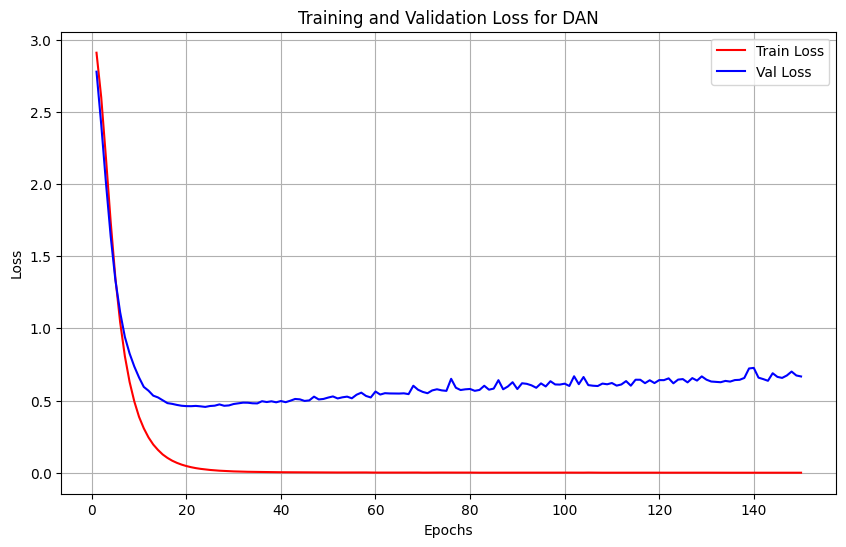

In [43]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits  
plot_loss(train_loss_over_time_dan, val_loss_over_time_dan, 'DAN')

### 4.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [44]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
load_checkpoint(dan_model, 'dan', map_location=device)

true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.55it/s]

Final Validation Accuracy: 0.8944297082228116
Final Validation F1-Score: 0.8919230926195209


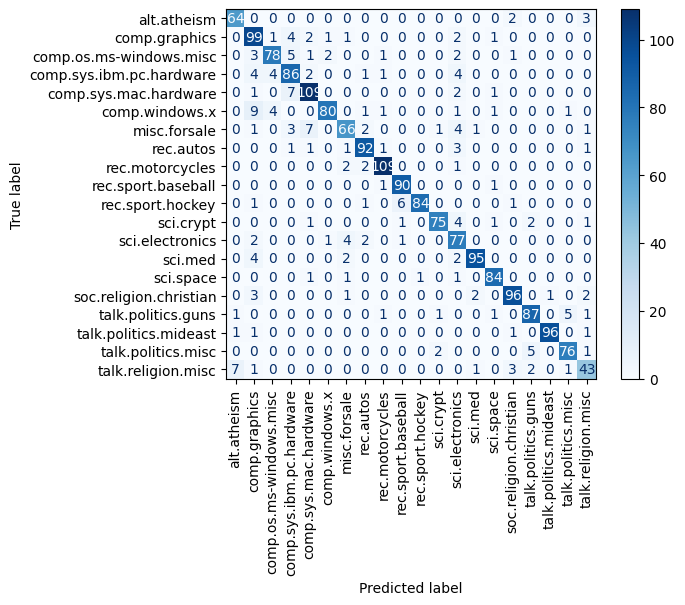

In [45]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 5. Attention-based Models [21 points - Programming + 9 points - Non-programming]
 In the simplest terms, attention allows a network to differentially focus on specific input words rather considering their importance equally, as done in the previous sections by averaging. For example, often times the mere presence of word "election" is enough to ascertain the category of the sentence to be politics. 

 There are various types of attention which we will dsicuss in much more depth throughout course. This section is just to provide a conceptual flavor of attention as a concept. In the below parts, you will work with three different simple types of attention. 

### 5.1. Attention-weighted NBOW [7 points - Programming + 3 points - Non-programming]



You will now define an encoder that uses a simple attention function to produce a weight for each word in the sentence followed by a sum of the attention-weighted word embeddings. Simple attention allows the model to learn a weight vector $\alpha_t$ which represents how important will different tokens in a document be.

Consider $u$ to be a single attention head (a learnable PyTorch parameter). With this,

$$ \alpha_t \varpropto \exp\{cos(u,emb(x_t))\} $$

*Note*: This needs to be normalized.

$$ h_{att} = \sum_t \alpha_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{att}) $$

where $w \in R^d$ is a parameter vector.

In this model, the unnormalized attention weight for a word $x$ is computed using the cosine similarity between a learnable parameter $u$ and the word embedding for $x$ followed by exponentiation. To get normalized weights $\alpha_t$, normalize across all words in the sentence. Then multiply the attention weights by the word embeddings and sum the attention-weighted embeddings.

*HINT*: See if Softmax function can help with this

*Hint*: Make sure to handle the case where the input contains pad tokens.

#### 5.1.1. Model Definition [5 points - Programming]

Define your simple attention model below.

In [46]:
#export

class SimpleAttentionNBOW(nn.Module):
    """
    This class implements the Attention-weighted Neural Bag of Words model.
    """
    
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SimpleAttentionNBOW, self).__init__()
        ## YOUR CODE STARTS HERE ##
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes

        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.attention = nn.Parameter(torch.randn(embedding_dim), requires_grad=True)  # Attention layer
        self.linear = nn.Linear(embedding_dim, num_classes, bias=False)  # Linear layer for classification

        ## YOUR CODE ENDS HERE ##
    
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        
        attn = self.get_attention_matrix(x)  # Get attention weights
        embeddings = self.get_embeddings(x)  # Get embeddings
        hidden = (embeddings * attn.unsqueeze(-1)).sum(dim=1)  # Apply attention weights
        predictions = self.linear(hidden)  # Pass through linear layer

        ## YOUR CODE ENDS HERE ##
        
        return predictions
    
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)

        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.embedding.weight = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###
            
    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.attention = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###
    
    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        '''
        ### YOUR CODE STARTS HERE ###
        embeddings = self.get_embeddings(x)
        attn = self.attention.expand(embeddings.size(0), embeddings.size(1), -1)
        cos_sim = torch.cosine_similarity(embeddings, attn, dim=-1)

        # Mask to ignore padding tokens
        mask = (x != 0)
        cos_sim = cos_sim.masked_fill(~mask, float('-inf'))

        return torch.softmax(cos_sim, dim=-1) * mask.float()

        ### YOUR CODE ENDS HERE ###
        

In [47]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def simple_attention_nbow_test_local_embeddings():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def simple_attention_nbow_test_local_attn():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([0.1, 0.2, 0.3]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.2033, 0.1995, 0.1975, 0.1964, 0.2033],
                                              [0.3387, 0.3323, 0.3290, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

simple_attention_nbow_test_local_embeddings()
simple_attention_nbow_test_local_attn()

Passed local embedding test
Passed local Attn test


#### 5.1.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [48]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_simple_attention():
  ### your hyper parameters
    learning_rate = 0.001
    epochs = 100
    embedding_dim = 64
    return learning_rate, epochs, embedding_dim

In [49]:
# export
def get_simple_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the SimpleAttentionNBOW model. Initialize the SimpleAttentionNBOW model here and return it.
    """
    ## YOUR CODE STARTS HERE ##

    model = SimpleAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)

    ## YOUR CODE ENDS HERE ##
    return model

In [50]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
criterion = get_criterion()
train_loss_over_time_sa = []
val_loss_over_time_sa = []
optimizer = get_optimizer(simple_attention_model, learning_rate)
for epoch in range(epochs):
    train_loss = train_loop(simple_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sa.append(train_loss)
    val_loss_over_time_sa.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(simple_attention_model, 'simple_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.35it/s]


Epoch 1 -- Train_Loss: 2.9657716912738348 -- Val_Loss: 2.932321612040202 -- Val_Accuracy: 0.15278514588859415 -- Val_F1: 0.11254538842010162


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 131.81it/s]


Epoch 2 -- Train_Loss: 2.8859146712190014 -- Val_Loss: 2.839094813664754 -- Val_Accuracy: 0.2403183023872679 -- Val_F1: 0.21123641706031426


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.99it/s]


Epoch 3 -- Train_Loss: 2.762287133831089 -- Val_Loss: 2.695765988032023 -- Val_Accuracy: 0.3140583554376658 -- Val_F1: 0.28264118445752184


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.87it/s]


Epoch 4 -- Train_Loss: 2.590745837001477 -- Val_Loss: 2.5163469473520914 -- Val_Accuracy: 0.3941644562334218 -- Val_F1: 0.36524347944470237


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.78it/s]


Epoch 5 -- Train_Loss: 2.3809519278801092 -- Val_Loss: 2.3116973559061686 -- Val_Accuracy: 0.4843501326259947 -- Val_F1: 0.4581084056310319


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.23it/s]


Epoch 6 -- Train_Loss: 2.1393915950241738 -- Val_Loss: 2.076266900698344 -- Val_Accuracy: 0.5580901856763926 -- Val_F1: 0.5321272021293021


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.53it/s]


Epoch 7 -- Train_Loss: 1.8759391651315205 -- Val_Loss: 1.8372441291809083 -- Val_Accuracy: 0.6408488063660478 -- Val_F1: 0.6186095936913707


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.30it/s]


Epoch 8 -- Train_Loss: 1.6096841268620248 -- Val_Loss: 1.6009438514709473 -- Val_Accuracy: 0.6976127320954907 -- Val_F1: 0.6787511924562728


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.30it/s]


Epoch 9 -- Train_Loss: 1.360779512736757 -- Val_Loss: 1.3870463530222574 -- Val_Accuracy: 0.7421750663129973 -- Val_F1: 0.728430432380667


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.98it/s]


Epoch 10 -- Train_Loss: 1.1418218971309015 -- Val_Loss: 1.205099089940389 -- Val_Accuracy: 0.7803713527851459 -- Val_F1: 0.7719867494303329


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.49it/s]


Epoch 11 -- Train_Loss: 0.9579388559874842 -- Val_Loss: 1.055695605278015 -- Val_Accuracy: 0.803183023872679 -- Val_F1: 0.7980563166372747


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.33it/s]


Epoch 12 -- Train_Loss: 0.8066307518441799 -- Val_Loss: 0.9270911574363708 -- Val_Accuracy: 0.8254641909814323 -- Val_F1: 0.8216854384257589


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.26it/s]


Epoch 13 -- Train_Loss: 0.6835159033031787 -- Val_Loss: 0.8284170587857564 -- Val_Accuracy: 0.8450928381962864 -- Val_F1: 0.8428909108993077


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.49it/s]


Epoch 14 -- Train_Loss: 0.583546113412259 -- Val_Loss: 0.7477890928586324 -- Val_Accuracy: 0.8503978779840848 -- Val_F1: 0.8486369783530673


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.63it/s]


Epoch 15 -- Train_Loss: 0.5019650257239907 -- Val_Loss: 0.6836634159088135 -- Val_Accuracy: 0.8625994694960212 -- Val_F1: 0.8596583681961555


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.56it/s]


Epoch 16 -- Train_Loss: 0.43475157401319275 -- Val_Loss: 0.6251341064771017 -- Val_Accuracy: 0.8673740053050398 -- Val_F1: 0.8644635261975134


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.89it/s]


Epoch 17 -- Train_Loss: 0.378700796325328 -- Val_Loss: 0.5812376976013184 -- Val_Accuracy: 0.8716180371352785 -- Val_F1: 0.8685732146011841


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.37it/s]


Epoch 18 -- Train_Loss: 0.33216367624068666 -- Val_Loss: 0.5405002435048422 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.876773677419566


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.63it/s]


Epoch 19 -- Train_Loss: 0.29252876707557907 -- Val_Loss: 0.5057528555393219 -- Val_Accuracy: 0.8854111405835544 -- Val_F1: 0.883424623548877


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.06it/s]


Epoch 20 -- Train_Loss: 0.2588810971227743 -- Val_Loss: 0.4785796284675598 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8887514862519744


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.65it/s]


Epoch 21 -- Train_Loss: 0.2297487959770833 -- Val_Loss: 0.4584022025267283 -- Val_Accuracy: 0.8938992042440318 -- Val_F1: 0.8911299606926433


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.72it/s]


Epoch 22 -- Train_Loss: 0.20467689267154468 -- Val_Loss: 0.4345740079879761 -- Val_Accuracy: 0.8986737400530505 -- Val_F1: 0.8959747365384534


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.80it/s]


Epoch 23 -- Train_Loss: 0.18272204962322267 -- Val_Loss: 0.4159305969874064 -- Val_Accuracy: 0.9050397877984084 -- Val_F1: 0.9022931009610499


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.10it/s]


Epoch 24 -- Train_Loss: 0.16363738830816948 -- Val_Loss: 0.4024808625380198 -- Val_Accuracy: 0.906631299734748 -- Val_F1: 0.9036592937706885


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.43it/s]


Epoch 25 -- Train_Loss: 0.14656941384329633 -- Val_Loss: 0.3876411199569702 -- Val_Accuracy: 0.9071618037135278 -- Val_F1: 0.9039297273593384


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.42it/s]


Epoch 26 -- Train_Loss: 0.13168641520758806 -- Val_Loss: 0.37576450904210407 -- Val_Accuracy: 0.9087533156498674 -- Val_F1: 0.9056537295101466


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.88it/s]


Epoch 27 -- Train_Loss: 0.11840437674673937 -- Val_Loss: 0.36423463026682534 -- Val_Accuracy: 0.9135278514588859 -- Val_F1: 0.9104828363219688


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.92it/s]


Epoch 28 -- Train_Loss: 0.10657566908936379 -- Val_Loss: 0.3522161185741425 -- Val_Accuracy: 0.9145888594164456 -- Val_F1: 0.9113916158287113


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.95it/s]


Epoch 29 -- Train_Loss: 0.09610346351134574 -- Val_Loss: 0.34640951255957286 -- Val_Accuracy: 0.9183023872679045 -- Val_F1: 0.915650450943331


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.88it/s]


Epoch 30 -- Train_Loss: 0.0866893754672196 -- Val_Loss: 0.33844460745652516 -- Val_Accuracy: 0.9193633952254642 -- Val_F1: 0.9167571816010216


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.27it/s]


Epoch 31 -- Train_Loss: 0.07827352587196787 -- Val_Loss: 0.33300547500451405 -- Val_Accuracy: 0.9214854111405836 -- Val_F1: 0.9194026696208774


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.17it/s]


Epoch 32 -- Train_Loss: 0.07073291258539184 -- Val_Loss: 0.324541375041008 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9196698836415125


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.18it/s]


Epoch 33 -- Train_Loss: 0.06398308065609407 -- Val_Loss: 0.3200487385193507 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.9204201603459449


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.43it/s]


Epoch 34 -- Train_Loss: 0.05789012686049534 -- Val_Loss: 0.31278216540813447 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9208875219517282


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.28it/s]


Epoch 35 -- Train_Loss: 0.05249914683212163 -- Val_Loss: 0.3078949848810832 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.9226046898657101


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.66it/s]


Epoch 36 -- Train_Loss: 0.04753222300718397 -- Val_Loss: 0.3064188301563263 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9243704274908741


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.95it/s]


Epoch 37 -- Train_Loss: 0.043192882311798755 -- Val_Loss: 0.2999684284130732 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9251632054992125


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.40it/s]


Epoch 38 -- Train_Loss: 0.03923370345037872 -- Val_Loss: 0.2989019145568212 -- Val_Accuracy: 0.9257294429708223 -- Val_F1: 0.923466195135372


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.85it/s]


Epoch 39 -- Train_Loss: 0.035691061451778576 -- Val_Loss: 0.2959068735440572 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9255831264063087


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.33it/s]


Epoch 40 -- Train_Loss: 0.032473668629713986 -- Val_Loss: 0.29173047343889874 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9272325678659014


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.92it/s]


Epoch 41 -- Train_Loss: 0.029635167349193057 -- Val_Loss: 0.2881899744272232 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9266304495606397


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.52it/s]


Epoch 42 -- Train_Loss: 0.02701897578219236 -- Val_Loss: 0.29008669356505073 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.9287264870411551


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.04it/s]


Epoch 43 -- Train_Loss: 0.024689928139165297 -- Val_Loss: 0.28290388683478035 -- Val_Accuracy: 0.929973474801061 -- Val_F1: 0.9277262437812052


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.32it/s]


Epoch 44 -- Train_Loss: 0.022567069015891877 -- Val_Loss: 0.28042713304360706 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.929088147023138


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.21it/s]


Epoch 45 -- Train_Loss: 0.020678978855327025 -- Val_Loss: 0.27934787968794506 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9282529674626794


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.78it/s]


Epoch 46 -- Train_Loss: 0.0189499618738132 -- Val_Loss: 0.2791593611240387 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.929648245112136


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.78it/s]


Epoch 47 -- Train_Loss: 0.01737907097153997 -- Val_Loss: 0.27400726278622944 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9284090378639712


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.01it/s]


Epoch 48 -- Train_Loss: 0.015968678684873602 -- Val_Loss: 0.27242907385031384 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.928772158869419


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.48it/s]


Epoch 49 -- Train_Loss: 0.014719081170446539 -- Val_Loss: 0.27433160146077473 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.928509665499368


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.31it/s]


Epoch 50 -- Train_Loss: 0.013513966992308023 -- Val_Loss: 0.2737166742483775 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9310822711564983


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.94it/s]


Epoch 51 -- Train_Loss: 0.012471777659256831 -- Val_Loss: 0.27217396994431814 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.9297167426355685


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.92it/s]


Epoch 52 -- Train_Loss: 0.011495137441177236 -- Val_Loss: 0.2705077519019445 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.9293893459243545


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.95it/s]


Epoch 53 -- Train_Loss: 0.010612510357809773 -- Val_Loss: 0.26828335026899974 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.92904094786893


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.79it/s]


Epoch 54 -- Train_Loss: 0.00981164085520905 -- Val_Loss: 0.26796204249064126 -- Val_Accuracy: 0.9320954907161804 -- Val_F1: 0.9299517974671916


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.32it/s]


Epoch 55 -- Train_Loss: 0.009048748122117782 -- Val_Loss: 0.2661073962847392 -- Val_Accuracy: 0.9320954907161804 -- Val_F1: 0.9303737005589447


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.67it/s]


Epoch 56 -- Train_Loss: 0.008371124395279813 -- Val_Loss: 0.26726113458474476 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.9295450656886283


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.84it/s]


Epoch 57 -- Train_Loss: 0.007782495864745924 -- Val_Loss: 0.2655160814523697 -- Val_Accuracy: 0.9331564986737401 -- Val_F1: 0.9309719072742448


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.36it/s]


Epoch 58 -- Train_Loss: 0.007226434078509525 -- Val_Loss: 0.26514985760053 -- Val_Accuracy: 0.9347480106100796 -- Val_F1: 0.9333270510058528


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.77it/s]


Epoch 59 -- Train_Loss: 0.006719109452313791 -- Val_Loss: 0.2699272314707438 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9328964827958043


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.61it/s]


Epoch 60 -- Train_Loss: 0.006250379613000836 -- Val_Loss: 0.26479812065760294 -- Val_Accuracy: 0.9347480106100796 -- Val_F1: 0.9332210471663999


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.93it/s]


Epoch 61 -- Train_Loss: 0.005832485941443908 -- Val_Loss: 0.26188341428836187 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9320477824716449


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.21it/s]


Epoch 62 -- Train_Loss: 0.0054528208082478685 -- Val_Loss: 0.26743391205867134 -- Val_Accuracy: 0.9347480106100796 -- Val_F1: 0.9331834537425273


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.04it/s]


Epoch 63 -- Train_Loss: 0.0050909862719413085 -- Val_Loss: 0.2615089058876038 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9324276120424912


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 145.01it/s]


Epoch 64 -- Train_Loss: 0.004761480846663274 -- Val_Loss: 0.26364836742480596 -- Val_Accuracy: 0.9347480106100796 -- Val_F1: 0.9331711967670924


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.71it/s]


Epoch 65 -- Train_Loss: 0.00447008989542186 -- Val_Loss: 0.2630359619855881 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9299190450136235


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.31it/s]


Epoch 66 -- Train_Loss: 0.004173160382641195 -- Val_Loss: 0.2636049896478653 -- Val_Accuracy: 0.9358090185676392 -- Val_F1: 0.9344245795096151


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.46it/s]


Epoch 67 -- Train_Loss: 0.003914833439798173 -- Val_Loss: 0.2634228110313416 -- Val_Accuracy: 0.9347480106100796 -- Val_F1: 0.9324771879151239


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.89it/s]


Epoch 68 -- Train_Loss: 0.00369358788366761 -- Val_Loss: 0.2667257209618886 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9317513455780192


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.50it/s]


Epoch 69 -- Train_Loss: 0.0034620910952009765 -- Val_Loss: 0.2631253133217494 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9326208780824112


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.80it/s]


Epoch 70 -- Train_Loss: 0.0032825946069906576 -- Val_Loss: 0.2634735157092412 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9311798829656468


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.92it/s]


Epoch 71 -- Train_Loss: 0.0030766316744798828 -- Val_Loss: 0.2609853823979696 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9304635085293128


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.69it/s]


Epoch 72 -- Train_Loss: 0.0029024108938509757 -- Val_Loss: 0.261768185098966 -- Val_Accuracy: 0.9347480106100796 -- Val_F1: 0.9330758447801987


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.99it/s]


Epoch 73 -- Train_Loss: 0.0027380299347973727 -- Val_Loss: 0.2614910195271174 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9326072472853593


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.48it/s]


Epoch 74 -- Train_Loss: 0.00258335340728636 -- Val_Loss: 0.2690152108669281 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9314764727053187


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.30it/s]


Epoch 75 -- Train_Loss: 0.0024399307173661004 -- Val_Loss: 0.2651575778921445 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9320843714524105


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.99it/s]


Epoch 76 -- Train_Loss: 0.002306749232279105 -- Val_Loss: 0.26565213650465014 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9317515997195762


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.46it/s]


Epoch 77 -- Train_Loss: 0.0021833981623107534 -- Val_Loss: 0.2643667037288348 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9314764727053187


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.42it/s]


Epoch 78 -- Train_Loss: 0.0020712539879210548 -- Val_Loss: 0.264827894171079 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.931487382884665


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.50it/s]


Epoch 79 -- Train_Loss: 0.0019786832474322073 -- Val_Loss: 0.26306481709082924 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.931487382884665


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.51it/s]


Epoch 80 -- Train_Loss: 0.0018825261489590788 -- Val_Loss: 0.26192364394664763 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9325415831818731


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.02it/s]


Epoch 81 -- Train_Loss: 0.0017772359256553701 -- Val_Loss: 0.26925062139829 -- Val_Accuracy: 0.9320954907161804 -- Val_F1: 0.9298120173455011


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.38it/s]


Epoch 82 -- Train_Loss: 0.0016729092068567682 -- Val_Loss: 0.26569628765185677 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.9293748072378815


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.57it/s]


Epoch 83 -- Train_Loss: 0.0015999513236269103 -- Val_Loss: 0.26064418181777 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9304321760840558


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.81it/s]


Epoch 84 -- Train_Loss: 0.0015187997211133903 -- Val_Loss: 0.2627122650543849 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9303944185616707


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.13it/s]


Epoch 85 -- Train_Loss: 0.0014576979624738886 -- Val_Loss: 0.26563744942347206 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9303296328926649


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.09it/s]


Epoch 86 -- Train_Loss: 0.0013916819431361253 -- Val_Loss: 0.26377737522125244 -- Val_Accuracy: 0.9331564986737401 -- Val_F1: 0.9307808174233486


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.98it/s]


Epoch 87 -- Train_Loss: 0.0013173601222106145 -- Val_Loss: 0.2629380534092585 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9303296328926649


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.50it/s]


Epoch 88 -- Train_Loss: 0.001265472654051984 -- Val_Loss: 0.26452937225500744 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9303296328926649


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 141.98it/s]


Epoch 89 -- Train_Loss: 0.0011998437509291916 -- Val_Loss: 0.26910052001476287 -- Val_Accuracy: 0.9331564986737401 -- Val_F1: 0.9309494412806266


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 144.51it/s]


Epoch 90 -- Train_Loss: 0.0011502688146843496 -- Val_Loss: 0.26594488074382144 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9303296328926649


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.81it/s]


Epoch 91 -- Train_Loss: 0.0011007831771305558 -- Val_Loss: 0.2724855735898018 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9303009593985696


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 139.73it/s]


Epoch 92 -- Train_Loss: 0.001061534085330727 -- Val_Loss: 0.26689559568961463 -- Val_Accuracy: 0.9331564986737401 -- Val_F1: 0.930960913849707


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.77it/s]


Epoch 93 -- Train_Loss: 0.0010204561830644292 -- Val_Loss: 0.26910623361666997 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.93036739041505


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.09it/s]


Epoch 94 -- Train_Loss: 0.0009677330100064371 -- Val_Loss: 0.2733848085006078 -- Val_Accuracy: 0.9331564986737401 -- Val_F1: 0.9309472889947074


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.14it/s]


Epoch 95 -- Train_Loss: 0.0009098892594427186 -- Val_Loss: 0.2670885692040125 -- Val_Accuracy: 0.9342175066312998 -- Val_F1: 0.9318415551194044


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.55it/s]


Epoch 96 -- Train_Loss: 0.0008703258995487655 -- Val_Loss: 0.26932158023118974 -- Val_Accuracy: 0.9331564986737401 -- Val_F1: 0.9308706676520668


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 142.39it/s]


Epoch 97 -- Train_Loss: 0.0008472983897525533 -- Val_Loss: 0.2669299155473709 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.9314288119595812


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 140.78it/s]


Epoch 98 -- Train_Loss: 0.0008068660999770608 -- Val_Loss: 0.2694851242005825 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.9304008322733732


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 143.56it/s]


Epoch 99 -- Train_Loss: 0.0007808302606601994 -- Val_Loss: 0.2707227309544881 -- Val_Accuracy: 0.9336870026525199 -- Val_F1: 0.931416843873668


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 137.18it/s]

Epoch 100 -- Train_Loss: 0.000747979035175808 -- Val_Loss: 0.26908798317114513 -- Val_Accuracy: 0.9326259946949602 -- Val_F1: 0.930419219531181
Checkpoint saved to /home/jblevins32/NLP_HW1/model_weights/checkpoint_simple_attention_ce.pt


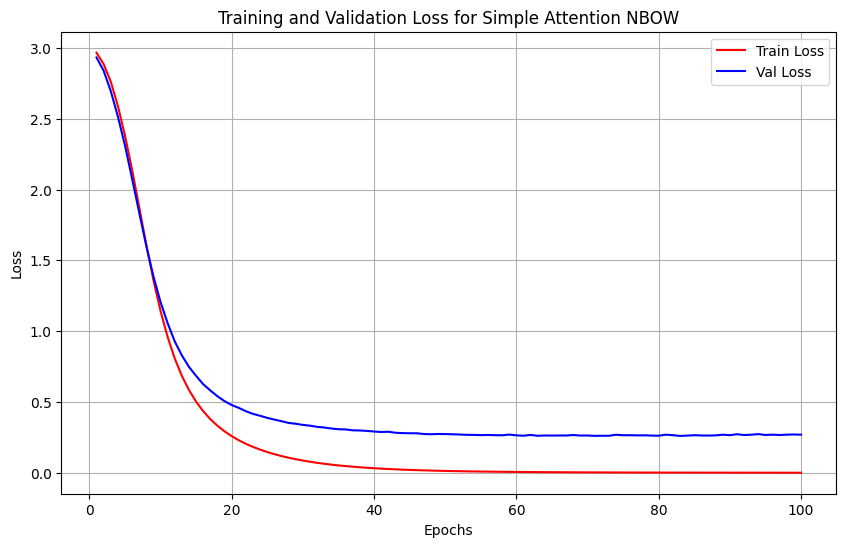

In [51]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits   
plot_loss(train_loss_over_time_sa, val_loss_over_time_sa, 'Simple Attention NBOW')

#### 5.1.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [52]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
load_checkpoint(simple_attention_model, 'simple_attention', map_location=device)

true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 138.21it/s]

Final Validation Accuracy: 0.9326259946949602
Final Validation F1-Score: 0.930419219531181


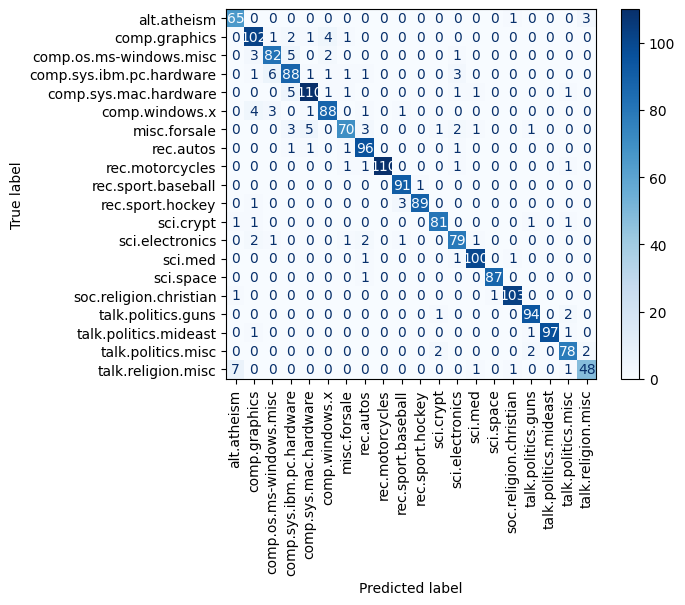

In [56]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.2. MultiHead Attention NBOW [7 points - Programming + 3 points - Non-programming]

The prior model only uses a single attention function. In this section, you will implement a multi-head attention model. You will use $k$ attention heads, each with its own parameters $u_i \in R^d$ ($\forall i \in [1..k]$) and a single large vector before the classification to weight them all together $w \in R^{d \cdot k}$. 

$$ \alpha_{t,i} \varpropto \exp\{cos(u_i,emb(x_t))\} $$

$$ h_{att}(i) = \sum_t\alpha_{t,i} emb(x_t) $$

With the probability of a task instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T [h_{att}(1), h_{att}(2), ..., h_{att}(k)]) $$

where [a,b] is the concatenation of vectors $a$ and $b$, into a single taller vector.

#### 5.2.1. Model Definition [5 points - Programming]

Define your Multi-head attention below

In [87]:
#export

class MultiHeadAttentionNBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_classes=20):
        ## YOUR CODE STARTS HERE ##
        super(MultiHeadAttentionNBOW, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_classes = num_classes

        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.attention = nn.Parameter(torch.randn(num_heads, embedding_dim), requires_grad=True)
        self.linear = nn.Linear(embedding_dim*num_heads, num_classes, bias=False)  # Linear layer for classification

        ## YOUR CODE ENDS HERE ##
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        
        attn_matrix = self.get_attention_matrix(x)
        embeddings = self.get_embeddings(x)
        hidden = (embeddings.unsqueeze(-2) * attn_matrix.unsqueeze(-1)).sum(dim=1)  # Apply attention weights and sum over vocab
        hidden_concat = hidden.reshape(hidden.size(0), -1)  # Reshape to (BATCH_SIZE, num_heads * embedding_dim)
        predictions = self.linear(hidden_concat)

        return predictions
        ## YOUR CODE ENDS HERE ##


    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)

        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.embedding.weight = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###
            
    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (num_heads, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###

        self.attention = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###

    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, num_heads))
        '''
        
        ### YOUR CODE STARTS HERE ###
        embeddings = self.get_embeddings(x).unsqueeze(-2) # BATCH_SIZE x max_seq_len x 1 x embedding_dim
        attn = self.attention.unsqueeze(0).unsqueeze(0)  # 1 x 1 x num_heads x embedding_dim 
        cos_sim = torch.cosine_similarity(embeddings, attn, dim=-1)

        # Mask to ignore padding tokens
        mask = (x != 0)
        for i in range(self.num_heads):
            cos_sim[:, :, i] = cos_sim[:, :, i].masked_fill(~mask, float('-inf'))

        return torch.softmax(cos_sim, dim=-2)

        ### YOUR CODE ENDS HERE ###

In [88]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def multihead_attn_nbow_test_local():
    embedding_dim = 10
    vocab_size = 10
    num_heads = 3
    model = MultiHeadAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_heads=num_heads)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % vocab_size
    expected_result = torch.tensor(
        [[2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000],
        [2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

# local test for sanity:
def multi_attention_nbow_test_local_embeddings():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def multi_attention_nbow_test_local_attn():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([[0.1, 0.2, 0.3],[0.1, 0.2, 0.3],[0.2, 0.2, 0.2],[0, 0.3, 0.3]]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[[0.2033, 0.2033, 0.1981, 0.2052],
                                                [0.1995, 0.1995, 0.2007, 0.1990],
                                                [0.1975, 0.1975, 0.2014, 0.1961],
                                                [0.1964, 0.1964, 0.2017, 0.1945],
                                                [0.2033, 0.2033, 0.1981, 0.2052]],

                                                [[0.3387, 0.3387, 0.3300, 0.3419],
                                                [0.3323, 0.3323, 0.3344, 0.3314],
                                                [0.3290, 0.3290, 0.3356, 0.3267],
                                                [0.0000, 0.0000, 0.0000, 0.0000],
                                                [0.0000, 0.0000, 0.0000, 0.0000]]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

multi_attention_nbow_test_local_embeddings()
multi_attention_nbow_test_local_attn()
multihead_attn_nbow_test_local()

Passed local embedding test
Passed local Attn test
Passed local check


#### 5.2.2. Model Training [3 points - Non-Programming]

Assign and tune the below hyperparameters to optimize your model

In [89]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_multihead():
    learning_rate = 0.001
    epochs = 100
    num_heads = 6
    embedding_dim = 64
    return learning_rate, epochs, num_heads, embedding_dim

In [90]:
#export
def get_multihead_attention_model(vocab_size, embedding_dim, num_heads):
    """
    This function returns an instance of the MultiHeadAttentionNBOW model. Initialize the MultiHeadAttentionNBOW model here and return it.
    """

    ## YOUR CODE STARTS HERE ##
    model = MultiHeadAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_heads=num_heads)
    ## YOUR CODE ENDS HERE ##
    return model

In [91]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
criterion = get_criterion()
optimizer = get_optimizer(multihead_attention_model, learning_rate)
train_loss_over_time_ma = []
val_loss_over_time_ma = []
for epoch in range(epochs):
    train_loss = train_loop(multihead_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_ma.append(train_loss)
    val_loss_over_time_ma.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(multihead_attention_model, 'multihead_attention')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits 
plot_loss(train_loss_over_time_ma, val_loss_over_time_ma, 'Multihead Attention NBOW')

#### 5.2.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [ ]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
load_checkpoint(multihead_attention_model, 'multihead_attention')

true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.3. Self-Attention NBOW [7 points - Programming + 3 points - Non-programming]

Self-attention is a mechanism in neural networks that enables each element in a sequence to consider and weigh the importance of every other element. This facilitates a more nuanced and context-aware representation of the sequence, greatly enhancing the capabilities of models in tasks involving sequential data, particularly in NLP. It has gained prominence with the introduction and success of Transformer models, like BERT, GPT (including GPT-3), and others. This is not a full-fledged implementation of it, but instead a conceptual flavor of the mechanism.

We will now define an encoder that uses a simple form of self-attention when producing attention weights for each word in the sentence:
$$a_{ts} = emb(x_t)^Temb(x_s)$$
$$α_t \propto exp(\sum_s a_{ts})$$
$$h_{self} = \sum α_temb(x_t)$$
Then, the probability of a class is given by
$$softmax(w^Th_{self})$$
The unnormalized attention weight for a word $x$ is computed using the dot product between its embedding and those for all other words in the sentence, followed by a summation and exponentiation. Unlike the model in Section 5.1., this model does not introduce any new parameters for computing the attention function, simply using the same word embeddings for the attention. Therefore, this model has the same number of parameters as the model in Section 2.
For improved stability, we can also add a “residual connection”, which would change Eq. 1 to
$$softmax(w^T(h_{self} + h_{avg}))$$
where $h_{avg}$ is computed as in Section 2 (though using the same word embeddings as in $h_{self}$).


#### 5.3.1. Model Definition [5 points - Programming]
Define your self attention model below

In [ ]:
#export
class SelfAttentionNBOW(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SelfAttentionNBOW, self).__init__()
        # YOUR CODE STARTS HERE
        pass # remove this when you add your implementation        
        # YOUR CODE ENDS HERE

    def forward(self, x):
        # YOUR CODE STARTS HERE
        pass # remove this when you add your implementation       
        # YOUR CODE ENDS HERE
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch)
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, max seq length in batch)
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    

In [ ]:
# local test for sanity:
def self_attention_nbow_test_local():
    model = SelfAttentionNBOW(vocab_size=10, embedding_dim=10)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % 10
    
    expected_result = torch.tensor(
        [[1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000],
        [1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def self_attention_nbow_test_local_embeddings():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5, 3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1, 2, 3, 4, 1], [1, 2, 3, 0, 0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")

def self_attention_nbow_test_local_attn():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.1675, 0.1921, 0.2203, 0.2526, 0.1675],
        [0.3085, 0.3327, 0.3588, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")
self_attention_nbow_test_local()
self_attention_nbow_test_local_embeddings()
self_attention_nbow_test_local_attn()


NameError: name 'SelfAttentionNBOW' is not defined

In [ ]:
#export
def get_self_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the Self Attention model. Initialize the Self Attention model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##

    ## YOUR CODE ENDS HERE ##
    return model

#### 5.3.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [ ]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_self_attn():
    learning_rate = None
    epochs = None
    embedding_dim = None
    return learning_rate, epochs, embedding_dim

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell 
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(self_attention_model, learning_rate)
train_loss_over_time_sea = []
val_loss_over_time_sea = []
for epoch in range(epochs):
    train_loss = train_loop(self_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sea.append(train_loss)
    val_loss_over_time_sea.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(self_attention_model, 'self_attention')

In [ ]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits 
plot_loss(train_loss_over_time_sea, val_loss_over_time_sea, 'Self Attention NBOW')

#### 5.3.3. Model Evaluation Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [ ]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
load_checkpoint(self_attention_model, 'self_attention', map_location=device)

true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 6. Perceptron and Hinge Losses (16 Points - Programming)



### 6.1. Perceptron Loss (5 points - Programming)

The perceptron loss penalizes the model only when the true class is not the most confident prediction. If the model incorrectly assigns a higher score to another class, the perceptron loss encourages the model to adjust its weights to fix this mistake.

This is achieved by considering the difference between the maximum score among all other classes and the score of the true class. If the maximum incorrect score is higher than the true class score, the model receives a penalty proportional to how much worse the true class was predicted compared to the highest incorrect class.

Given a set of predictions from the perceptron model for a batch of samples, we denote:

- $ \mathbf{y} \in \mathbb{R}^{B \times C} $: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j $ be the score for class $j$ (from the predicted score vector).
- $ s_{\text{true}} $ be the score for the true class.

The **perceptron loss** for data instance $x_i$ is defined as:

$$
L_{\text{perceptron}}(i) = \max \left( 0, \max_{j} (s_j) - s_{\text{true}} \right)
$$

For batches, we compute the loss for each sample and take the mean over the batch

Implement this PerceptronLoss in the forward method below.

NOTE: The scores are logits, the predictions of models before doing any softmax.


In [ ]:
# export

class PerceptronLoss(nn.Module):
    def __init__(self):
        super(PerceptronLoss, self).__init__()

    def forward(self, predictions, labels):
        """
        Calculate the perceptron loss between predictions and labels.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean perceptron loss for the batch.
        """
        loss = None
        # YOUR CODE STARTS HERE

        # YOUR CODE ENDS HERE
        return loss

In [ ]:
# DO NOT CHANGE THIS CELL
perceptron_loss = PerceptronLoss()

def test_correct_classification():
    predictions = torch.tensor([[3.0, 2.0, 1.0],
                                [1.0, 4.0, 2.0]])
    labels = torch.tensor([0, 1])
    loss = perceptron_loss(predictions, labels).item()
    expected_loss = 0.0
    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for correct classification')
    else:
        print(f"Test case failed for correct classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Test for incorrect classification
def test_incorrect_classification():
    predictions = torch.tensor([[1.0, 3.0, 2.0],
                                [1.0, 2.0, 4.0]])
    labels = torch.tensor([0, 1])
    
    expected_loss = 2.0
    loss = perceptron_loss(predictions, labels).item()
    
    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for incorrect classification')
    else:
        print(f"Test case failed for incorrect classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Execute test cases
test_correct_classification()
test_incorrect_classification()

### 6.2. NBOW Training using Perceptron Loss (3 points - Programming)

Credits will be awarded as per the following final results on the Gradescope split -
- 0 points for accuracy <= 75%
- 1 point for accuracy > 75% but <= 80% 
- 2 points for accuracy > 80%

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = PerceptronLoss()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_perceptron = []
val_loss_over_time_perceptron = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_perceptron.append(train_loss)
    val_loss_over_time_perceptron.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    
save_checkpoint(nbow_model, 'nbow', loss_fn='perceptron')

In [ ]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_perceptron, val_loss_over_time_perceptron, 'NBOW with Perceptron Loss')

In [ ]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint 
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'perceptron', map_location=device)

# evaluate model 
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 6.3. Hinge Loss (5 points - Programming)

Read through the dataset documentation link provided with this notebook, or feel free to Google and read about 20 Newsgroups dataset, it's quite popular. If you try to understand the labels, they are more similar to some of them than others, semantically. For example, `talk.politics.mideast` is more closer to `talk.politics.misc` than `sci.space`. 

Mathematically speaking, it means that misclassification of a label to some classes may be less penalizable than some other classes. This is the perfect scenario of using hinge loss.

The **hinge loss** is another loss function commonly used for classification, especially in **support vector machines (SVMs)**. It is designed to maximize the margin between the decision boundary and the closest data points from each class.

The hinge loss penalizes predictions based on how confident the model is about the correct class relative to other classes. It aims to push the score of the true class far above the scores of all other classes, ensuring that the model not only predicts the correct class but does so confidently.

For each input sample $x_i$, the model computes a score for each class. The hinge loss compares the score for the true class to the scores for all other classes and penalizes the model if the true class score is not sufficiently higher than the scores for the other classes.

Given a set of predictions from the model for a batch of samples, we denote:

- $\mathbf{y} \in \mathbb{R}^{B \times C}$: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j$ be the score for class $j$ (from the predicted score vector).
- $s_{\text{true}}$ be the score for the true class.
- $l(j, true)$ be the cost if a task instance belonging to $true$ has highest score for $j$

The **hinge loss** for a task instance \( x_i \) is defined as:

$$
L_{\text{hinge}}(i) = \max \left( 0, \max_j\left(s_j + l(j, true)\right) - s_{\text{true}}\right)
$$

For batches, we compute the loss for each sample and take the mean over the batch to obtain a scalar value representing the average hinge loss.

HINT: The non-recommended solution is to use one loop. However, it is highly recommended to not do that for efficiency reasons. `torch.gather()` should be helpful.


In [ ]:
# export
class HingeLoss(nn.Module):
    def __init__(self, cost_matrix, device):
        super(HingeLoss, self).__init__()
        """
        cost_matrix is a 2D list. Convert it to a tensor on appropriate device.
        """
        # YOUR CODE STARTS HERE

        # YOUR CODE ENDS HERE

    def forward(self, predictions, labels):
        """
        Calculate the hinge loss between predictions and labels, adjusting for cost.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean hinge loss for the batch, adjusted for the defined cost.
        """
        loss = None
        # YOUR CODE STARTS HERE

        # YOUR CODE ENDS HERE
        return loss

In [ ]:
# DO NOT CHANGE THIS CELL
def test_correct_classification(hinge_loss):
    """
    Test case where the true class has the highest score.
    The loss should be 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[3.0, 2.0, 1.0], 
                                [1.0, 4.0, 2.0]])  
    labels = torch.tensor([0, 1])  
    loss = hinge_loss(predictions, labels).item()
    expected_loss = 0.0
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 1 passed')
    else:
        print(f"Test case 1 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")
    
def test_incorrect_classification(hinge_loss):
    """
    Test case where the true class does not have the highest score.
    The loss should be greater than 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[1.0, 3.0, 2.0], 
                                [1.0, 2.0, 4.0]])  
    labels = torch.tensor([0, 1])  

    expected_loss = 3.0
    loss = hinge_loss(predictions, labels).item()
    
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 2 passed')
    else:
        print(f"Test case 2 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")
        
cost_matrix = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
hinge_loss = HingeLoss(costslack_matrix, device='cpu')
test_correct_classification(hinge_loss)
test_incorrect_classification(hinge_loss)

### 6.4. NBOW Training using Hinge Loss [3 points - Programming]

First, define a cost matrix. Take inspiration from the confusion matrix of `PerceptronLoss` results, `id2label` map and your knowledge of what dataset labels are. This will help is constructing a good cost matrix.

Credits will be awarded on the following cutoffs on Gradescope split -
- 0 points for accuracy <= 84%, 
- 1 point for accuracy > 84% but <= 88%, 
- 2 points for accuracy > 88%

In [ ]:
# export
def get_cost_matrix(num_classes=20):
    """
    Generates a cost matrix for a specified number of classes using Python lists.

    Args:
        num_classes (int): The number of classes for which the cost matrix is to be created.

    Returns:
        list of lists: A 2D list where element (i, j) is the absolute difference between i and j,
                       set to zero if i equals j.
    """
    cost_matrix = None
    # YOUR CODE STARTS HERE

    # YOUR CODE ENDS HERE
    return cost_matrix

In [ ]:
# DO NOT CHANGE THIS CELL
def test_cost(matrix):
    n = len(matrix)
    
    # Check if the matrix is square
    for row in matrix:
        if len(row) != n:
            print('Incorrect cost matrix: Not a square matrix.')
    
    # Check for symmetry and zero diagonal elements
    for i in range(n):
        if matrix[i][i] != 0:
            print('Incorrect cost matrix: Diagonal elements are not zero.')
        
        for j in range(i + 1, n):
            if matrix[i][j] != matrix[j][i]:
                print('Incorrect cost matrix: Not a symmetric matrix.')
    
    print('Valid cost matrix')

cost_matrix = get_cost_matrix()
test_cost(cost_matrix)

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
cost_matrix = get_cost_matrix()
criterion = HingeLoss(cost_matrix, device=device)
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_hinge = []
val_loss_over_time_hinge = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_hinge.append(train_loss)
    val_loss_over_time_hinge.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    
save_checkpoint(nbow_model, 'nbow', loss_fn='hinge')

In [ ]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_hinge, val_loss_over_time_hinge, 'NBOW with Hinge Loss')

In [ ]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint 
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'hinge', map_location=device)

# evaluate model 
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 7. Analysis [21 Points - Non-programming]

These are some analytical questions based on implementations done above.

Note for all analysis questions: Be sure to isolate all your code/textual answers into separate cells without modifying code in other exported functions as they are still used for grade scope test cases. Feel free to add as many code and markdown cells as you see fit to explain your answer.

Code should be in code cells and write-ups should strictly be in markdown cells. Please note, these will be manually evaluated due to large variation in possible answers. So, visibility of code, explanation and output in the PDF is the key.

### 7.1. Analyzing NBOW Weights [7 points - Non-programming]

Load your trained `NBOW` model here, and let $w$ be the weight of your linear layer of the model. It will be of the shape of `(num_classes, embedding_dim)`.

For this tensor, compute $ww^T$ and show it as a heatmap (a sample code to generate heatmap is shown below). 

Explain the generated output. What does it resemble? What do high and low values of coefficients at position i, j indicate? With the help of the dataset documentation and `id2label` map displayed earlier in this notebook, can you reason why certain values are high and why certain values are low? What does it tell you about the class labels?

In [ ]:
# YOUR CODE HERE
# Example Heatmap Generation Code
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # Display heatmap using Matplotlib
# plt.imshow(matrix, cmap='hot', interpolation='nearest')
# plt.colorbar()  # Add a color bar to show the scale
# plt.title('Heatmap using Matplotlib')
# plt.show()

YOUR ANSWER HERE

### 7.2. Word Embeddings and the Attention Vector [7 points - Non Programming]

From your trained `SimpleAttentionNBOW` model, analyze all word embeddings and the attention vector `u`. Look at the words which have the highest cosine similarity with `u`. Print the 15 words with highest cosine similarity to `u` and the 15 with lowest cosine similarity to `u`. Why do you think those words have high/low cosine similarity to `u` (and therefore high/low attention weights on average)? Form a hypothesis to explain what you see.

In [ ]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 7.3. Analysis of Cost Matrix in Hinge Loss [7 points - Non-programming]

Display the confusion matrices of prediction of `NBOW` with `PerceptronLoss` and `HingeLoss`. Also print the cost matrix you used for the Hinge Loss. 

Using this confusion matrix, `id2label` mapping provided earlier, your knowledge about what labels in the dataset represent, explain the motivation behind creating the provided cost matrix. Why were some of the coefficients higher than others (if)?

In [ ]:
# YOUR CODE HERE

YOUR ANSWER HERE

## 8. Improving Attention Models [BONUS] [10 points - Non-programming]

Hopefully you’ve developed some intuition for using attention for this task. Now, come up with your own ways of modifying the attention function and experiment with them. Can you find an idea that outperforms your models from Sections 5?
Some potential ideas are below:
- Use transformation matrices to distinguish key, query, and value representations
- Add additional layers of self-attention before the attention-weighted sum of embeddings
- Compute features in the attention function based on characteristics of where the word is in the sentence, e.g., features of the sentence length, nearby words, the presence of negation words before or after the word, information from a part-of-speech tagger or syntactic parse of the sentence, etc.
- Use multiple word embedding spaces for when words are used as keys, queries, and values, or some subset of the three.

Describe your best new attention function formally below, along with the execution code and experimental results. Add as many code and markdown cells as you want, and submit the complete working with explanation.

## 9. Submitting Your Assignment

This is the end. Congratulations!  

Now, follow the steps below to submit your homework on Gradescope.

### 9.1. Programming

The programming will be evaluated through an autograder. To create the file to submit for autograder, follow the steps below -
1. Open a terminal from the root directory of the project
2. Run the collect_submission.py file
3. Agree to the Late Policy and Honor Pledge
4. After the file is executed, your root project will have a submission directory.
5. Submit all the contents of this file to GradeScope

### 9.2. Non-Programming

The analysis parts will be evaluated manually. For this, export the notebook to a PDF file, and submit it on GradeScope. Please ensure no written code or output is clipped when you create your PDF. One reliable way to do it is first download it as HTML through Jupyter Notebook and then print it to get PDF.